# EDA và Trực quan hóa dữ liệu Amazon Sales

In [178]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from pywaffle import Waffle
from wordcloud import WordCloud
import squarify
import plotly.express as px
import plotly.graph_objects as go
import warnings
# warnings.filterwarnings('ignore')

# Thiết lập style ggplot cho matplotlib
plt.style.use('ggplot')
sns.set_palette("husl")

# Cấu hình hiển thị
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Thiết lập kích thước mặc định cho biểu đồ
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


In [ ]:
# Tải dữ liệu đã làm sạch
df = pd.read_csv('Amazon_SaleData_Cleaned.csv')

# Chuyển đổi OrderDate sang datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Tạo các biến phụ trợ cho phân tích
df['Year'] = df['OrderDate'].dt.year
df['Month'] = df['OrderDate'].dt.month
df['Quarter'] = df['OrderDate'].dt.quarter
df['YearMonth'] = df['OrderDate'].dt.to_period('M')
df['DayOfWeek'] = df['OrderDate'].dt.day_name()
df['MonthName'] = df['OrderDate'].dt.month_name()
df['DayOfMonth'] = df['OrderDate'].dt.day

# Tính toán các metrics bổ sung

print(f"Dataset shape: {df.shape}")
print(f"Thời gian: {df['OrderDate'].min()} đến {df['OrderDate'].max()}")
print(f"\nĐã tải dữ liệu và tạo các biến phụ trợ thành công!")
df.head(10)

Dataset shape: (100000, 29)
Thời gian: 2020-01-01 00:00:00 đến 2024-12-29 00:00:00

Đã tải dữ liệu và tạo các biến phụ trợ thành công!


OrderID  OrderDate  CustomerID   CustomerName ProductID  \
0  ORD0000001 2023-01-31  CUST001504  Vihaan Sharma    P00014   
1  ORD0000002 2023-12-30  CUST000178    Pooja Kumar    P00040   
2  ORD0000003 2022-05-10  CUST047516    Sneha Singh    P00044   
3  ORD0000004 2023-07-18  CUST030059   Vihaan Reddy    P00041   
4  ORD0000005 2023-02-04  CUST048677  Aditya Kapoor    P00029   
5  ORD0000006 2022-12-31  CUST042705   Karan Sharma    P00023   
6  ORD0000007 2024-09-20  CUST037667    Aarav Verma    P00030   
7  ORD0000008 2022-11-10  CUST031165    Rohit Kumar    P00028   
8  ORD0000009 2024-06-26  CUST026965    Aman Kapoor    P00031   
9  ORD0000010 2020-05-01  CUST029472    Aarav Reddy    P00001   

           ProductName           Category       Brand  Quantity  UnitPrice  \
0           Drone Mini              Books   BrightLux         3     106.59   
1           Microphone     Home & Kitchen  UrbanStyle         1     251.37   
2  Power Bank 20000mAh           Clothing  UrbanStyle         3      35.03   
3       Webcam Full HD     Home & Kitchen      Zenith         5      33.58   
4              T-Shirt           Clothing    KiddoFun         2     515.64   
5         Cookware Set              Books    ReadMore         4     449.73   
6          Dress Shirt           Clothing  UrbanStyle         2     219.81   
7                Jeans       Toys & Games    KiddoFun         2     306.51   
8         Kids Toy Car  Sports & Outdoors        Apex         4     146.09   
9     Wireless Earbuds           Clothing        Apex         2     278.21   

   Discount    Tax  ShippingCost  TotalAmount     PaymentMethod OrderStatus  \
0      0.00   0.00          0.09       319.86        Debit Card   Delivered   
1      0.05  19.10          1.74       259.64        Amazon Pay   Delivered   
2      0.10   7.57          5.91       108.06        Debit Card   Delivered   
3      0.15  11.42          5.53       159.66  Cash On Delivery   Delivered   
4      0.25  38.67          9.23       821.36       Credit Card   Cancelled   
5      0.00 215.87          2.74      2017.53               Upi   Delivered   
6      0.20  28.14         14.97       394.81               Upi   Delivered   
7      0.05  29.12          6.24       617.73        Debit Card     Pending   
8      0.00  46.75          7.03       638.14        Debit Card   Delivered   
9      0.10  60.09          4.88       565.75       Credit Card   Delivered   

          City State        Country   SellerID  day_of_week  Revenue  Year  \
0   Washington    DC          India  SELL01967            1   319.86  2023   
1   Fort Worth    TX  United States  SELL01298            5   259.64  2023   
2       Austin    TX  United States  SELL00908            1   108.06  2022   
3    Charlotte    NC          India  SELL01164            1   159.66  2023   
4  San Antonio    TX         Canada  SELL01411            5     0.00  2023   
5  Los Angeles    CA  United States  SELL01494            5  2017.53  2022   
6      Chicago    IL      Australia  SELL01676            4   394.81  2024   
7       Denver    CO          India  SELL00510            3     0.00  2022   
8   Washington    DC  United States  SELL01895            2   638.14  2024   
9      Houston    TX  United States  SELL01584            4   565.75  2020   

   Month  Quarter YearMonth  DayOfWeek  MonthName  DayOfMonth  
0      1        1   2023-01    Tuesday    January          31  
1     12        4   2023-12   Saturday   December          30  
2      5        2   2022-05    Tuesday        May          10  
3      7        3   2023-07    Tuesday       July          18  
4      2        1   2023-02   Saturday   February           4  
5     12        4   2022-12   Saturday   December          31  
6      9        3   2024-09     Friday  September          20  
7     11        4   2022-11   Thursday   November          10  
8      6        2   2024-06  Wednesday       June          26  
9      5        2   2020-05     Friday        May           1

### Q1: Giá sản phẩm được phân phối như thế nào?

Phân tích phân bố của UnitPrice để hiểu mức giá phổ biến và độ lệch của dữ liệu.

In [138]:
dup = df.duplicated("OrderID").sum()
print("Duplicate OrderID rows:", dup)

# nếu có duplicate, xem mỗi OrderID có bao nhiêu status khác nhau
tmp = df.groupby("OrderID")["OrderStatus"].nunique().sort_values(ascending=False)
print("Max distinct statuses per OrderID:", tmp.max())
print("Orders with >1 status rows:", (tmp > 1).sum())

Duplicate OrderID rows: 0
Max distinct statuses per OrderID: 1
Orders with >1 status rows: 0


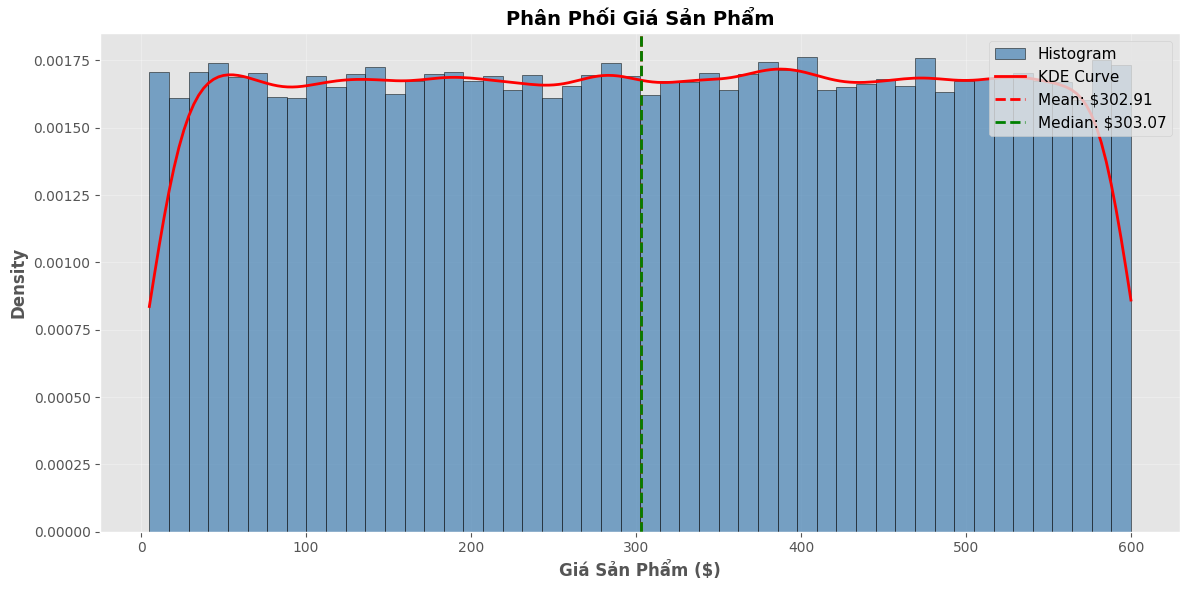

In [139]:
fig, ax = plt.subplots(figsize=(12, 6))
n, bins, patches = ax.hist(df['UnitPrice'], bins=50, density=True, alpha=0.7, 
                           color='steelblue', edgecolor='black', label='Histogram')

# Thêm KDE curve
data_clean = df['UnitPrice'].dropna()
if len(data_clean) > 1:
    kde = gaussian_kde(data_clean)
    x_range = np.linspace(data_clean.min(), data_clean.max(), 200)
    ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE Curve')

# Thêm các đường thống kê
mean_val = df['UnitPrice'].mean()
median_val = df['UnitPrice'].median()
ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: ${mean_val:,.2f}')
ax.axvline(median_val, color='green', linestyle='--', linewidth=2, 
           label=f'Median: ${median_val:,.2f}')

ax.set_title('Phân Phối Giá Sản Phẩm', fontweight='bold', fontsize=14)
ax.set_xlabel('Giá Sản Phẩm ($)', fontweight='bold', fontsize=12)
ax.set_ylabel('Density', fontweight='bold', fontsize=12)
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Q2: Số lượng mua mỗi đơn được phân phối như thế nào?

Phân tích Quantity để xem hành vi mua lẻ hay mua số lượng lớn chiếm ưu thế.

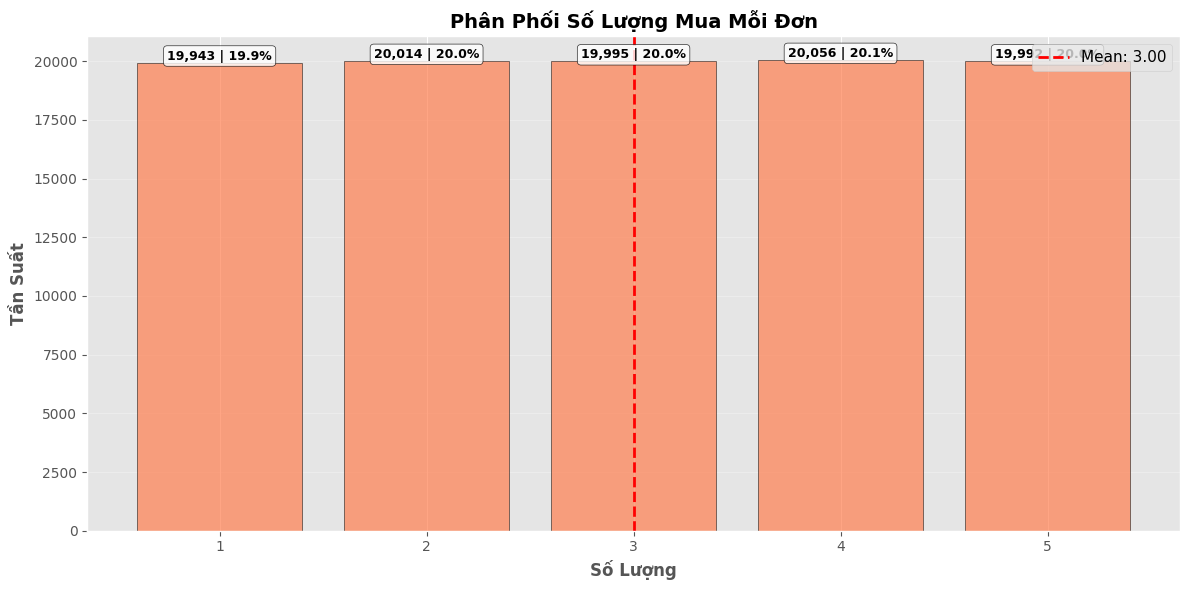

In [140]:
quantity_counts = df["Quantity"].value_counts().sort_index()
total = len(df)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(
    quantity_counts.index,
    quantity_counts.values,
    edgecolor="black",
    alpha=0.7,
    color="coral",
)

# Thêm annotations cho các giá trị quan trọng
for qty, count in quantity_counts.items():
    if count > total * 0.03:  # Chỉ hiển thị các giá trị chiếm > 3%
        percentage = (count / total) * 100
        value = f"{count:,} | {percentage:.1f}%"
        ax.text(
            qty,
            count,
            value,
            ha="center",
            va="bottom",
            bbox=dict(
                facecolor="white", edgecolor="black", boxstyle="round", alpha=0.8
            ),
            fontweight="bold",
            fontsize=9,
        )

ax.axvline(
    df["Quantity"].mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f'Mean: {df["Quantity"].mean():.2f}',
)
ax.set_title("Phân Phối Số Lượng Mua Mỗi Đơn", fontweight="bold", fontsize=14)
ax.set_xlabel("Số Lượng", fontweight="bold", fontsize=12)
ax.set_ylabel("Tần Suất", fontweight="bold", fontsize=12)
ax.legend(loc="upper right", fontsize=11)
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

**Nhận xét:**
- Phân phối số lượng mua cho thấy hành vi mua sắm của khách hàng. Nếu phân phối tập trung ở số lượng nhỏ (1-3), khách hàng có xu hướng mua lẻ.
- Nếu có nhiều đơn hàng với số lượng lớn (>5), điều này cho thấy có segment khách hàng mua số lượng lớn, có thể là doanh nghiệp hoặc mua để bán lại.
- Phân tích này giúp xác định chiến lược inventory và pricing phù hợp với từng nhóm khách hàng.

### Q3: Tỷ lệ các trạng thái đơn hàng là bao nhiêu?

Phân tích tỷ lệ các trạng thái như Delivered, Cancelled nhằm đánh giá hiệu quả xử lý đơn hàng.

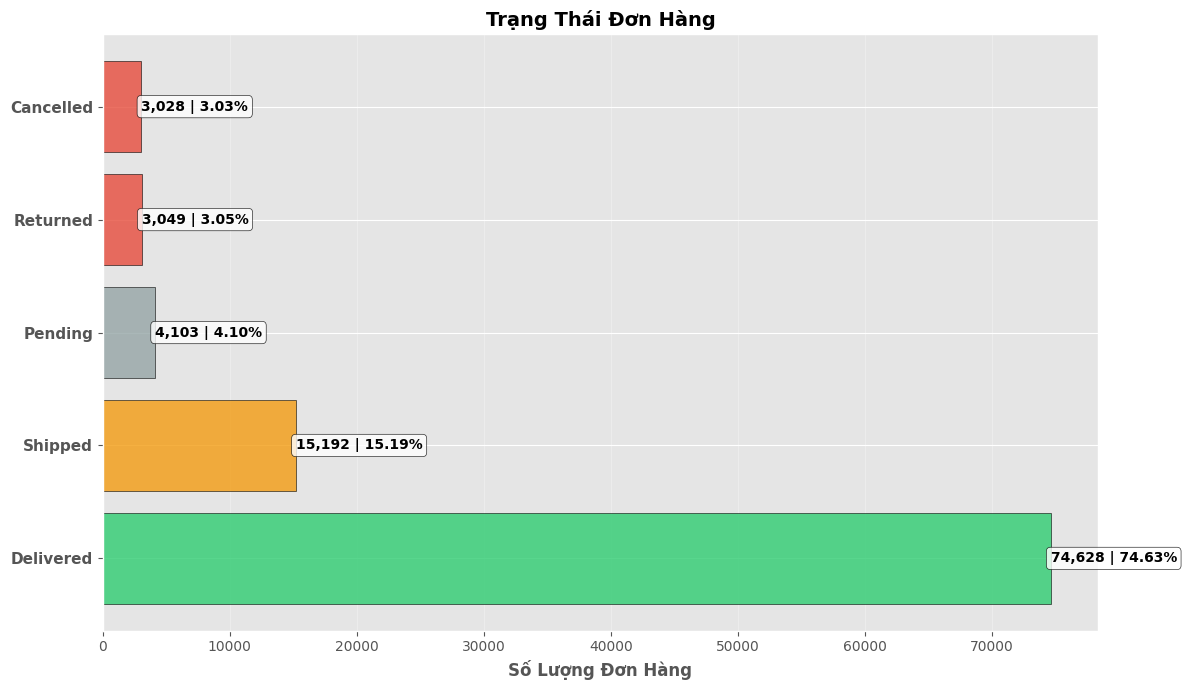

In [141]:
status_counts = df['OrderStatus'].value_counts()
total = status_counts.sum()
colors_status = ['#2ecc71' if s == 'Delivered' else '#f39c12' if s == 'Shipped' 
                else '#e74c3c' if s in ['Cancelled', 'Returned'] else '#95a5a6' 
                for s in status_counts.index]

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(range(len(status_counts)), status_counts.values, 
              color=colors_status, edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(status_counts)))
ax.set_yticklabels(status_counts.index, fontweight='bold', fontsize=11)
ax.set_xlabel('Số Lượng Đơn Hàng', fontweight='bold', fontsize=12)
ax.set_title('Trạng Thái Đơn Hàng', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')

# Thêm annotations với count và percentage
for i, (idx, count) in enumerate(status_counts.items()):
    percentage = (count / total) * 100
    value = f'{count:,} | {percentage:.2f}%'
    ax.text(count, i, value, ha='left', va='center', 
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=0.8),
           fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

**Nhận xét:**
- Tỷ lệ đơn hàng "Delivered" cao cho thấy hiệu quả xử lý đơn hàng tốt và hệ thống logistics hoạt động ổn định.
- Tỷ lệ đơn hàng bị hủy (Cancelled) hoặc trả lại (Returned) thấp phản ánh chất lượng sản phẩm và dịch vụ tốt, tăng độ tin cậy của khách hàng.
- Các đơn hàng đang trong quá trình vận chuyển (Shipped) cho thấy quy trình được quản lý chặt chẽ và có tracking rõ ràng.

### Q4: Phương thức thanh toán nào phổ biến nhất?

Phân tích mức độ phổ biến của các phương thức thanh toán khác nhau.

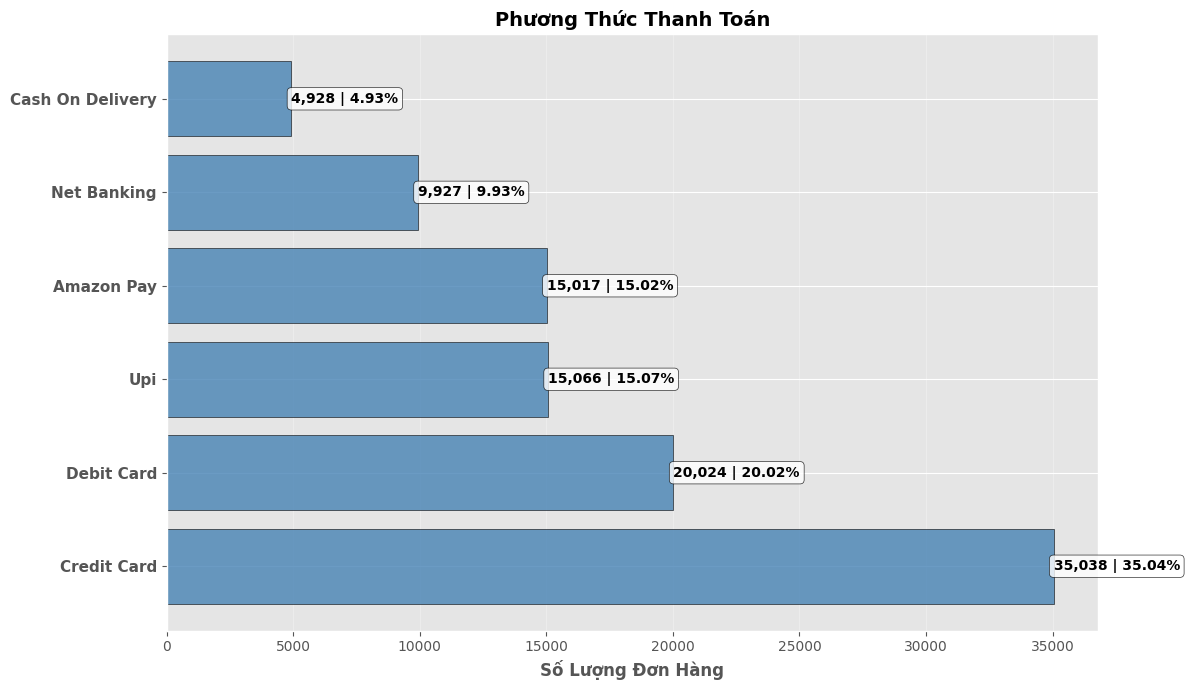

In [142]:
payment_counts = df["PaymentMethod"].value_counts()
total = payment_counts.sum()

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(
    range(len(payment_counts)),
    payment_counts.values,
    color="steelblue",
    edgecolor="black",
    alpha=0.8,
)
ax.set_yticks(range(len(payment_counts)))
ax.set_yticklabels(payment_counts.index, fontweight="bold", fontsize=11)
ax.set_xlabel("Số Lượng Đơn Hàng", fontweight="bold", fontsize=12)
ax.set_title("Phương Thức Thanh Toán", fontweight="bold", fontsize=14)
ax.grid(True, alpha=0.3, axis="x")

# Thêm annotations với count và percentage
for i, (idx, count) in enumerate(payment_counts.items()):
    percentage = (count / total) * 100
    value = f"{count:,} | {percentage:.2f}%"
    ax.text(
        count,
        i,
        value,
        ha="left",
        va="center",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round", alpha=0.8),
        fontweight="bold",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

**Nhận xét:**
- Phương thức thanh toán phổ biến nhất chiếm tỷ lệ cao, cho thấy khách hàng có sự lựa chọn rõ ràng và tập trung vào một số phương thức ưa thích.
- Sự phân bố không đều giữa các phương thức thanh toán phản ánh thói quen và sở thích của khách hàng, cũng như mức độ tiện lợi của từng phương thức.
- Phân tích này giúp xác định phương thức thanh toán cần được ưu tiên phát triển và marketing để tăng trải nghiệm khách hàng.

### Q5: Category nào có số lượng đơn hàng cao nhất?

So sánh mức độ phổ biến của các danh mục sản phẩm.

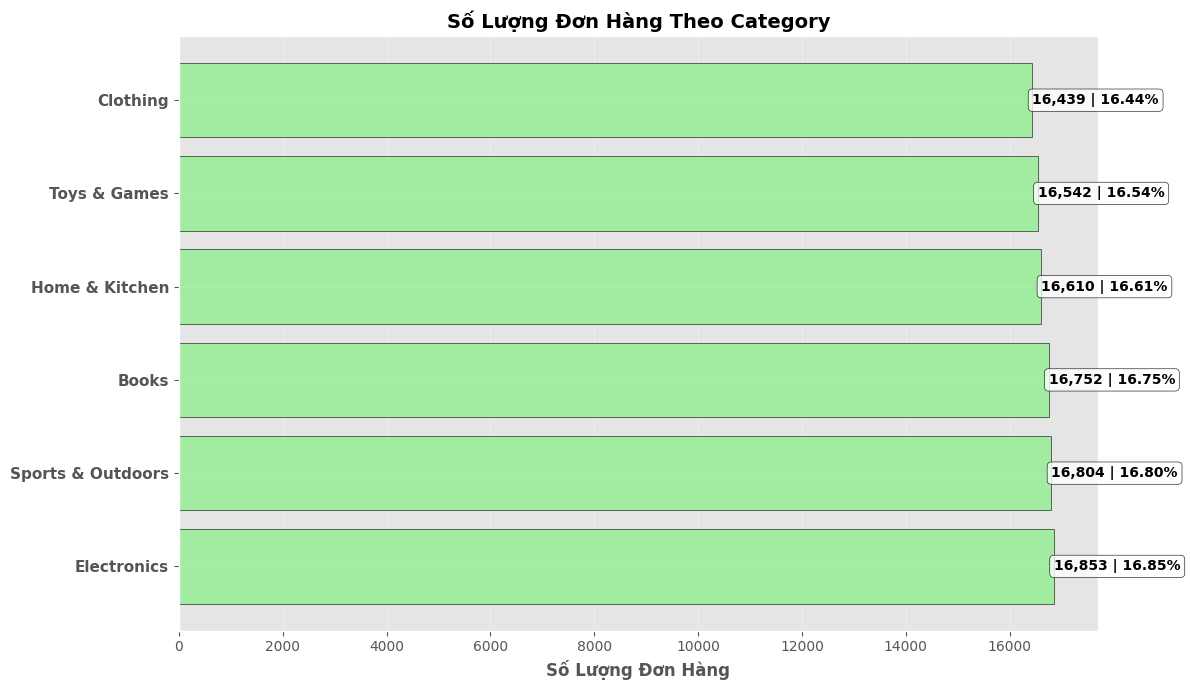

In [143]:
category_counts = df['Category'].value_counts().sort_values(ascending=False)
total = category_counts.sum()

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(range(len(category_counts)), category_counts.values, 
              color='lightgreen', edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(category_counts)))
ax.set_yticklabels(category_counts.index, fontweight='bold', fontsize=11)
ax.set_xlabel('Số Lượng Đơn Hàng', fontweight='bold', fontsize=12)
ax.set_title('Số Lượng Đơn Hàng Theo Category', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')

# Thêm annotations với count và percentage
for i, (idx, count) in enumerate(category_counts.items()):
    percentage = (count / total) * 100
    value = f'{count:,} | {percentage:.2f}%'
    ax.text(count, i, value, ha='left', va='center', 
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=0.8),
           fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

**Nhận xét:**
- Category có số lượng đơn hàng cao nhất cho thấy đây là danh mục được khách hàng ưa chuộng nhất, có thể do nhu cầu cao hoặc giá cả phù hợp.
- Sự chênh lệch giữa các category phản ánh sự khác biệt về mức độ phổ biến và nhu cầu thị trường.
- Phân tích này giúp xác định category cần được ưu tiên trong inventory management và marketing strategy để tối ưu hóa doanh thu.

### Q6: Danh mục nào tạo ra doanh thu cao nhất?

Phân tích doanh thu của từng danh mục để xác định category đóng góp nhiều nhất vào doanh thu.

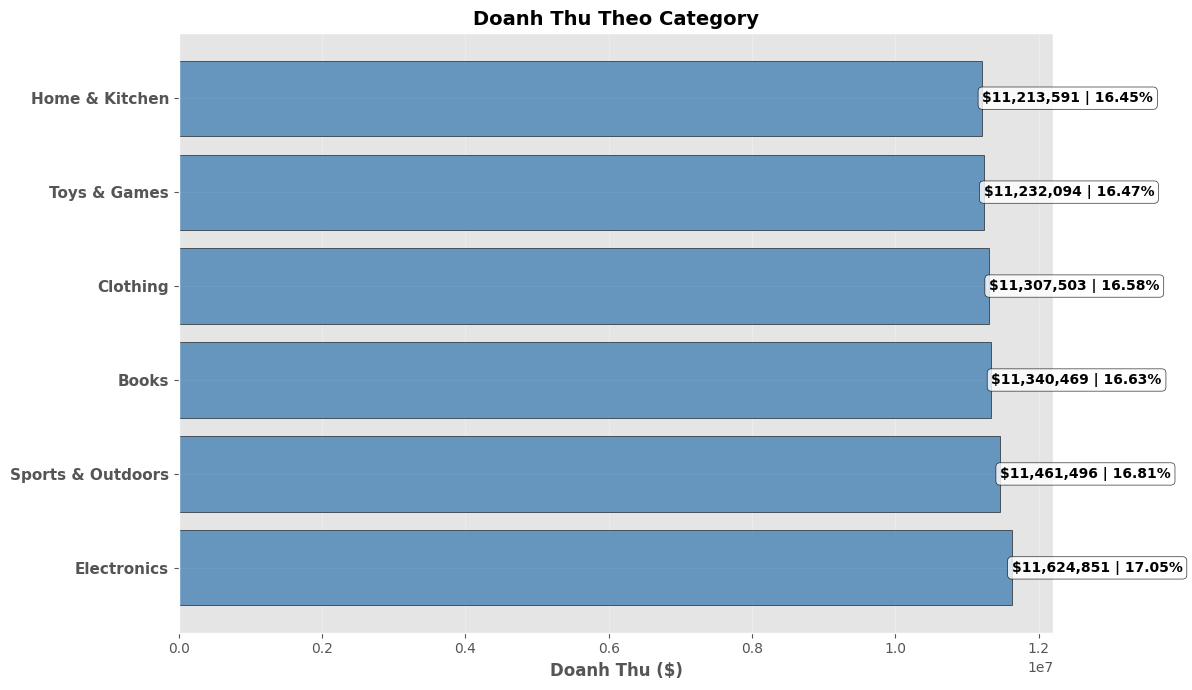

In [144]:
category_revenue = df.groupby("Category")["Revenue"].sum().sort_values(ascending=False)
total_revenue = category_revenue.sum()

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(
    range(len(category_revenue)),
    category_revenue.values,
    color="steelblue",
    edgecolor="black",
    alpha=0.8,
)
ax.set_yticks(range(len(category_revenue)))
ax.set_yticklabels(category_revenue.index, fontweight="bold", fontsize=11)
ax.set_xlabel("Doanh Thu ($)", fontweight="bold", fontsize=12)
ax.set_title("Doanh Thu Theo Category", fontweight="bold", fontsize=14)
ax.grid(True, alpha=0.3, axis="x")

# Thêm annotations với count và percentage
for i, (idx, revenue) in enumerate(category_revenue.items()):
    percentage = (revenue / total_revenue) * 100
    value = f"${revenue:,.0f} | {percentage:.2f}%"
    ax.text(
        revenue,
        i,
        value,
        ha="left",
        va="center",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round", alpha=0.8),
        fontweight="bold",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

**Nhận xét:**
- Category có doanh thu cao nhất là động lực chính của business, cần được ưu tiên trong chiến lược marketing và inventory.
- Sự chênh lệch doanh thu giữa các category phản ánh sự khác biệt về giá trị sản phẩm và nhu cầu thị trường.
- Category có doanh thu thấp có thể cần được đánh giá lại về pricing strategy hoặc có thể là niche market với tiềm năng phát triển.

### Q7: Top 10 thương hiệu nào dẫn đầu về doanh thu?

Xác định các thương hiệu dẫn đầu về doanh thu.

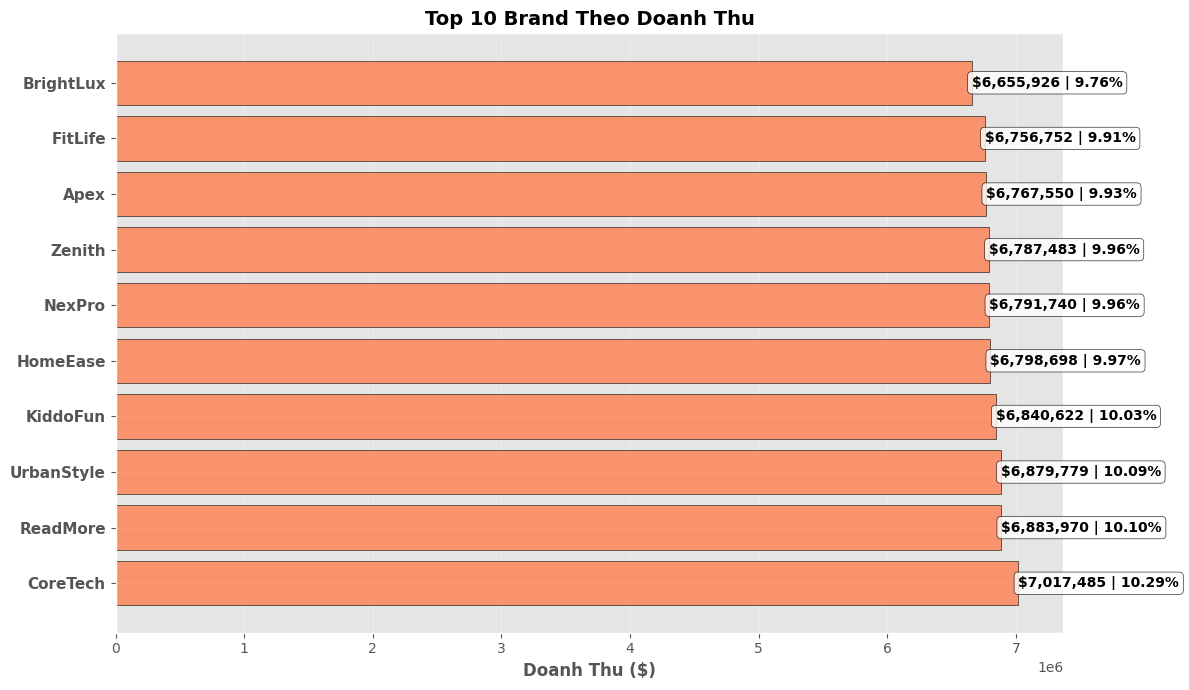

In [145]:
brand_revenue = (
    df.groupby("Brand")["Revenue"].sum().sort_values(ascending=False).head(10)
)
total_revenue = df["Revenue"].sum()

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(
    range(len(brand_revenue)),
    brand_revenue.values,
    color="coral",
    edgecolor="black",
    alpha=0.8,
)
ax.set_yticks(range(len(brand_revenue)))
ax.set_yticklabels(brand_revenue.index, fontweight="bold", fontsize=11)
ax.set_xlabel("Doanh Thu ($)", fontweight="bold", fontsize=12)
ax.set_title("Top 10 Brand Theo Doanh Thu", fontweight="bold", fontsize=14)
ax.grid(True, alpha=0.3, axis="x")

# Thêm annotations với count và percentage
for i, (idx, revenue) in enumerate(brand_revenue.items()):
    percentage = (revenue / total_revenue) * 100
    value = f"${revenue:,.0f} | {percentage:.2f}%"
    ax.text(
        revenue,
        i,
        value,
        ha="left",
        va="center",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round", alpha=0.8),
        fontweight="bold",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

**Nhận xét:**
- Top 10 brand chiếm tỷ lệ doanh thu cao cho thấy sự tập trung của thị trường vào một số thương hiệu nổi bật.
- Brand dẫn đầu về doanh thu thường có brand recognition tốt, chất lượng sản phẩm được đánh giá cao, hoặc có chiến lược marketing hiệu quả.
- Phân tích này giúp xác định các brand cần được ưu tiên trong partnership và inventory management để tối ưu hóa doanh thu.

### Q8: Doanh thu có xu hướng tăng trưởng hay suy giảm theo thời gian?

Phân tích xu hướng doanh thu theo thời gian để phát hiện tăng trưởng hoặc suy giảm.

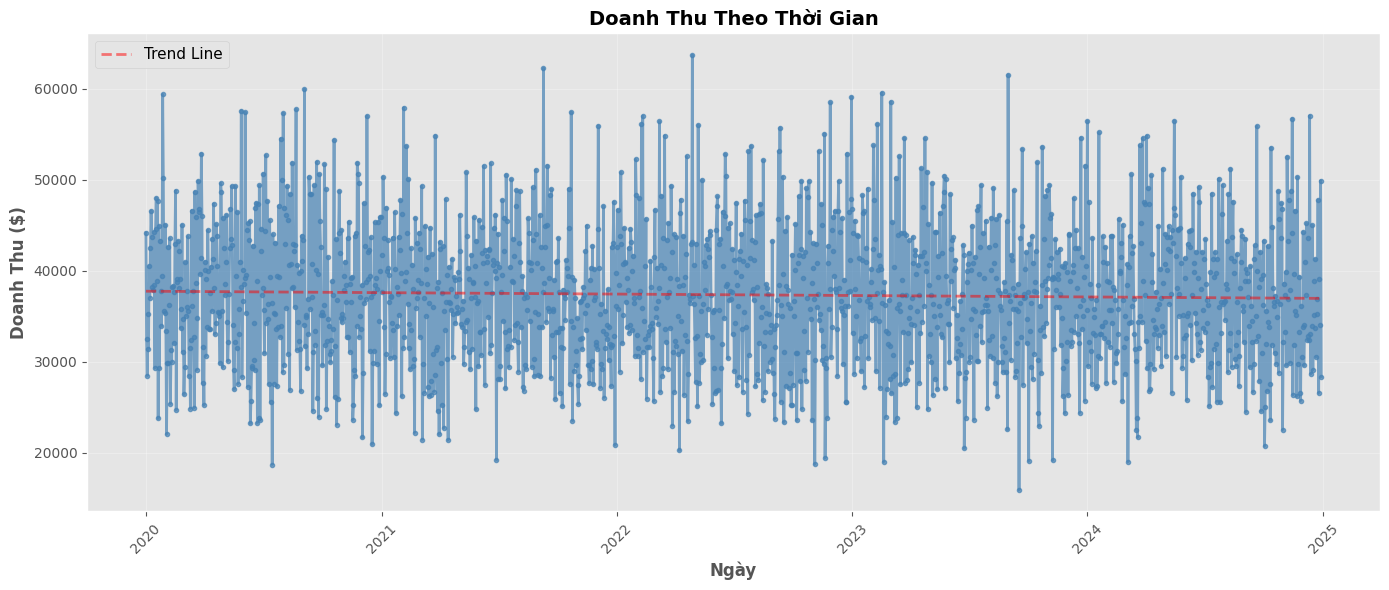

In [146]:
revenue_by_date = df.groupby("OrderDate")["Revenue"].sum().reset_index()
revenue_by_date = revenue_by_date.sort_values("OrderDate")

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(
    revenue_by_date["OrderDate"],
    revenue_by_date["Revenue"],
    linewidth=2,
    color="steelblue",
    marker="o",
    markersize=3,
    alpha=0.7,
)

# Thêm trend line
z = np.polyfit(range(len(revenue_by_date)), revenue_by_date["Revenue"], 1)
p = np.poly1d(z)
ax.plot(
    revenue_by_date["OrderDate"],
    p(range(len(revenue_by_date))),
    "r--",
    alpha=0.5,
    linewidth=2,
    label="Trend Line",
)

ax.set_title("Doanh Thu Theo Thời Gian", fontweight="bold", fontsize=14)
ax.set_xlabel("Ngày", fontweight="bold", fontsize=12)
ax.set_ylabel("Doanh Thu ($)", fontweight="bold", fontsize=12)
ax.legend(loc="upper left", fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Nhận xét:**
- Xu hướng doanh thu theo thời gian cho thấy sự tăng trưởng hoặc suy giảm của business. Trend line đi lên cho thấy business đang phát triển tốt.
- Các điểm peak và valley trong biểu đồ có thể phản ánh các sự kiện đặc biệt (promotion, holiday, seasonality) ảnh hưởng đến doanh thu.
- Phân tích này giúp dự báo doanh thu trong tương lai và lập kế hoạch marketing theo thời điểm phù hợp.

### Q9: Số lượng đơn hàng thay đổi như thế nào theo từng tháng?

Phân tích xu hướng mua sắm theo mùa vụ.

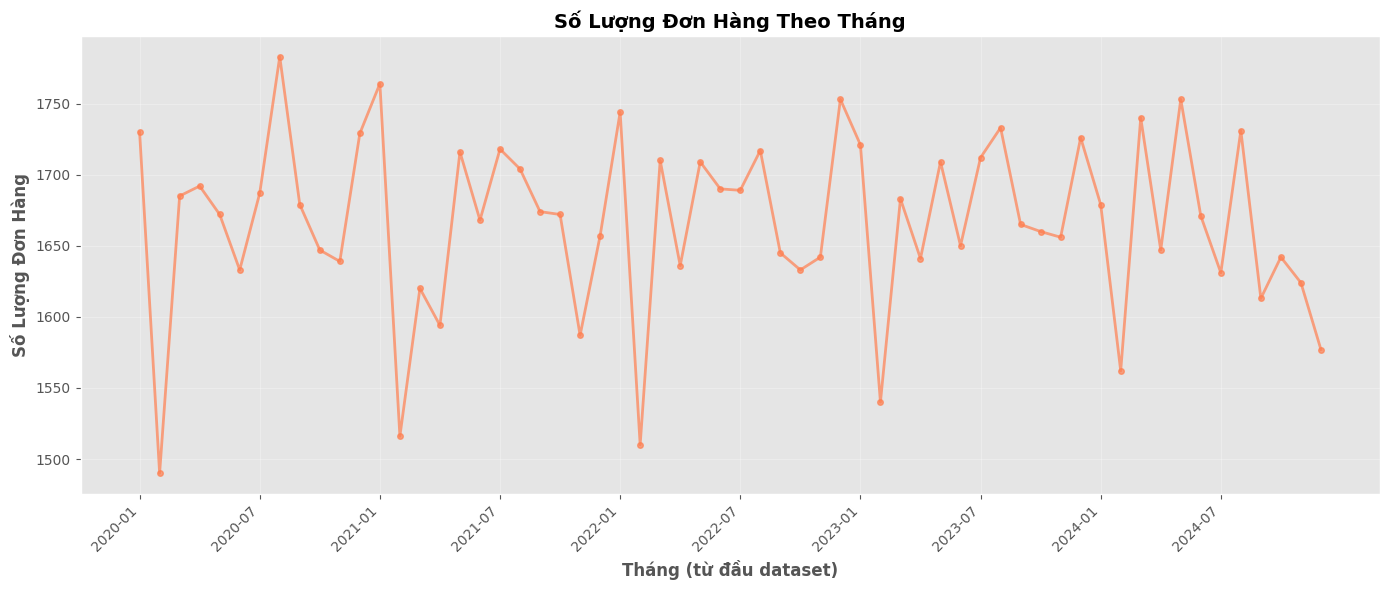

In [147]:
orders_by_month = df.groupby("YearMonth")["OrderID"].count().reset_index()
orders_by_month["YearMonth"] = orders_by_month["YearMonth"].astype(str)
orders_by_month = orders_by_month.sort_values("YearMonth")

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(
    range(len(orders_by_month)),
    orders_by_month["OrderID"],
    linewidth=2,
    color="coral",
    marker="o",
    markersize=4,
    alpha=0.7,
)

ax.set_title("Số Lượng Đơn Hàng Theo Tháng", fontweight="bold", fontsize=14)
ax.set_xlabel("Tháng (từ đầu dataset)", fontweight="bold", fontsize=12)
ax.set_ylabel("Số Lượng Đơn Hàng", fontweight="bold", fontsize=12)
ax.set_xticks(range(0, len(orders_by_month), max(1, len(orders_by_month) // 10)))
ax.set_xticklabels(
    [
        orders_by_month.iloc[i]["YearMonth"]
        for i in range(0, len(orders_by_month), max(1, len(orders_by_month) // 10))
    ],
    rotation=45,
    ha="right",
)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Nhận xét:**
- Xu hướng số lượng đơn hàng theo tháng cho thấy patterns mua sắm theo mùa vụ. Các tháng có số đơn cao thường là các tháng có sự kiện đặc biệt (Black Friday, holiday season).
- Sự biến động trong số lượng đơn hàng phản ánh nhu cầu thị trường và hiệu quả của các chiến dịch marketing.
- Phân tích này giúp lập kế hoạch inventory và staffing theo từng tháng để đáp ứng nhu cầu khách hàng tốt nhất.

### Q10: Doanh thu giữa các năm khác nhau như thế nào theo từng tháng?

So sánh doanh thu giữa các năm theo từng tháng để phát hiện xu hướng tăng trưởng.

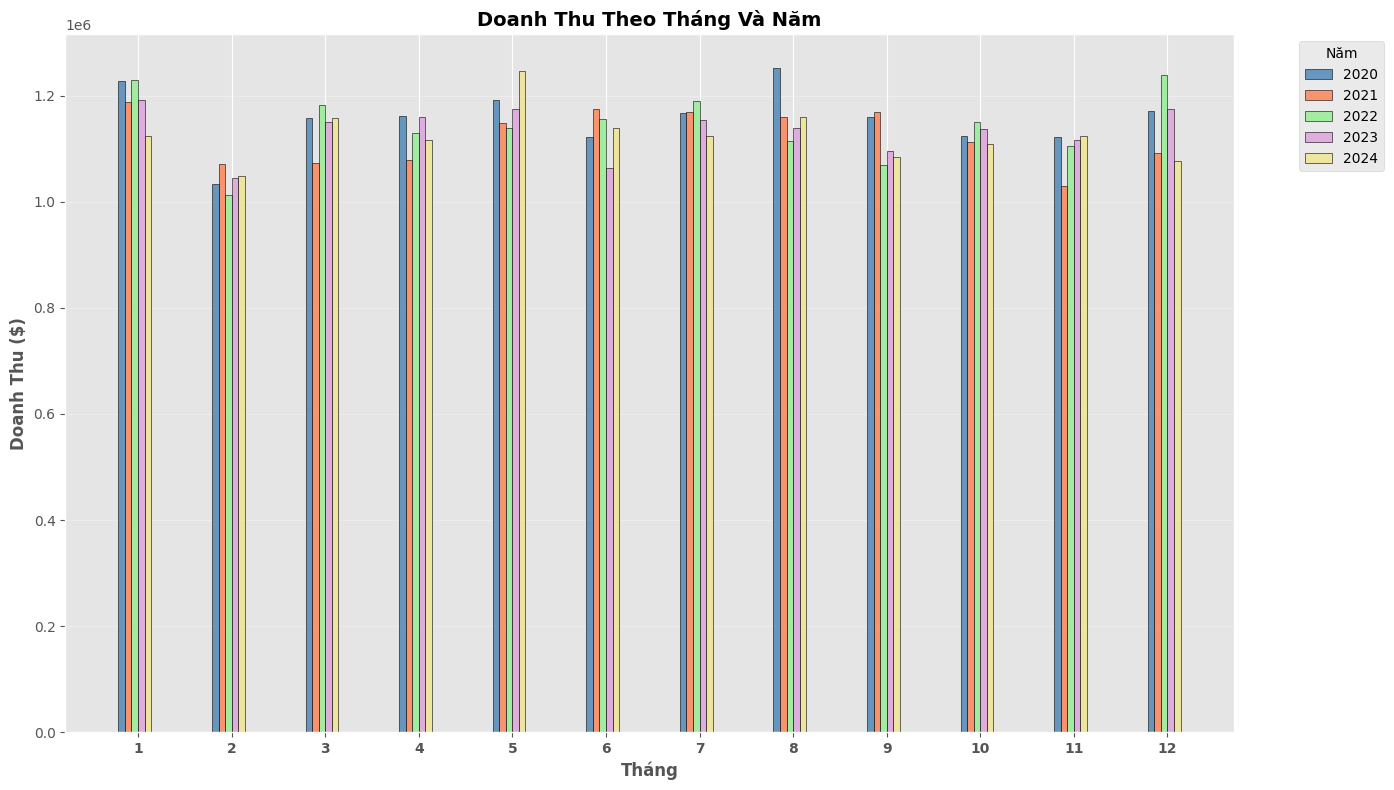

In [148]:
revenue_by_month_year = df.groupby(['Year', 'Month'])['Revenue'].sum().reset_index()
revenue_pivot = revenue_by_month_year.pivot(index='Month', columns='Year', values='Revenue').fillna(0)

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(revenue_pivot.index))
width = 0.35

years = revenue_pivot.columns.tolist()
colors = ['steelblue', 'coral', 'lightgreen', 'plum', 'khaki']
for i, year in enumerate(years):
    offset = (i - len(years)/2) * width / len(years)
    ax.bar(x + offset, revenue_pivot[year], width/len(years), 
           label=str(year), color=colors[i % len(colors)], alpha=0.8, edgecolor='black')

ax.set_xlabel('Tháng', fontweight='bold', fontsize=12)
ax.set_ylabel('Doanh Thu ($)', fontweight='bold', fontsize=12)
ax.set_title('Doanh Thu Theo Tháng Và Năm', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(revenue_pivot.index, fontweight='bold')
ax.legend(title='Năm', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

**Nhận xét:**
- Xu hướng số lượng đơn hàng theo tháng cho thấy patterns mua sắm theo mùa vụ. Các tháng có số đơn cao thường là các tháng có sự kiện đặc biệt (Black Friday, holiday season).
- Sự biến động trong số lượng đơn hàng phản ánh nhu cầu thị trường và hiệu quả của các chiến dịch marketing.
- Phân tích này giúp lập kế hoạch inventory và staffing theo từng tháng để đáp ứng nhu cầu khách hàng tốt nhất.

### Q11: Giảm giá có ảnh hưởng đến tổng số tiền chi tiêu không?

Đánh giá ảnh hưởng của giảm giá đến số lượng mua.

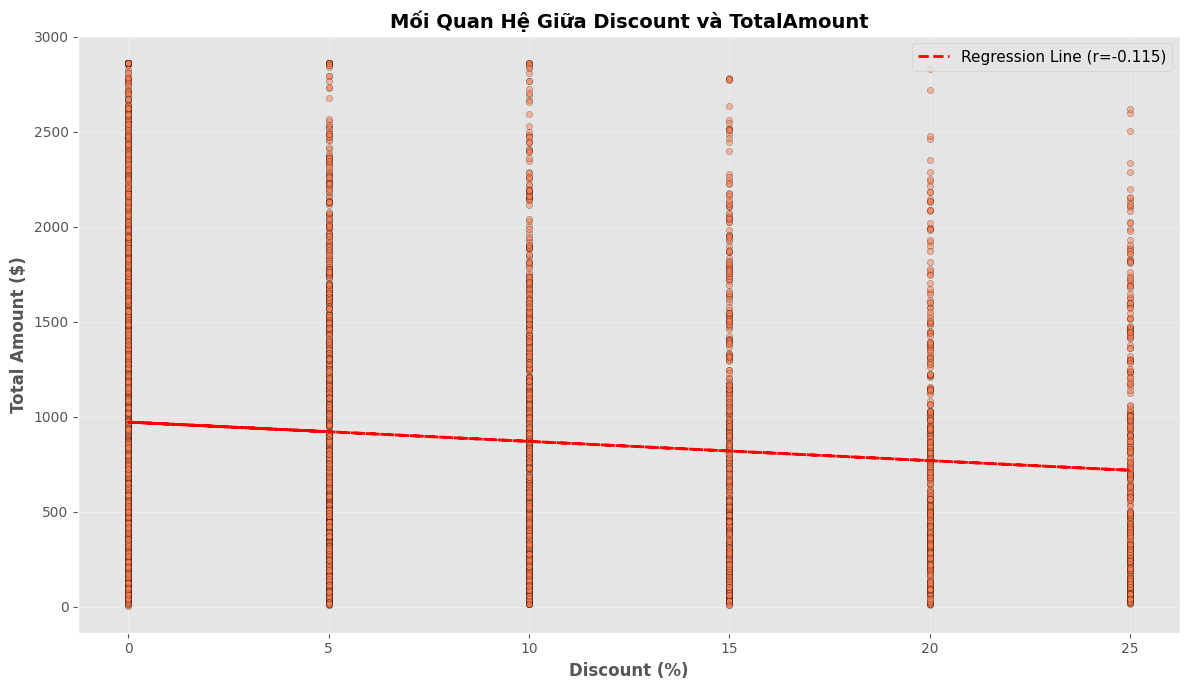

In [149]:
# Lấy sample để tránh quá nhiều điểm trên scatter plot
sample_size = min(5000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

fig, ax = plt.subplots(figsize=(12, 7))
scatter = ax.scatter(df_sample['Discount']*100, df_sample['TotalAmount'], 
                     alpha=0.5, s=20, color='coral', edgecolors='black', linewidth=0.3)

# Thêm regression line
from scipy import stats
x = df_sample['Discount']*100
y = df_sample['TotalAmount']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept
ax.plot(x, line, 'r--', linewidth=2, label=f'Regression Line (r={r_value:.3f})')

ax.set_xlabel('Discount (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('Total Amount ($)', fontweight='bold', fontsize=12)
ax.set_title('Mối Quan Hệ Giữa Discount và TotalAmount', fontweight='bold', fontsize=14)
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Nhận xét:**
- Scatter plot cho thấy mối quan hệ giữa discount và số lượng mua. Nếu có xu hướng tích cực (discount cao, quantity cao), discount có tác động tích cực đến việc tăng số lượng mua.
- Nếu không có mối quan hệ rõ ràng, điều này cho thấy khách hàng không chỉ mua dựa trên discount mà còn dựa trên các yếu tố khác (nhu cầu, chất lượng, brand).
- Phân tích này giúp xác định chiến lược discount tối ưu để cân bằng giữa việc tăng số lượng bán và giảm profit margin.

### Q12: Giá trị đơn hàng khác nhau như thế nào giữa các trạng thái?

So sánh giá trị đơn hàng giữa các trạng thái khác nhau.

/tmp/ipykernel_362410/1204632853.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


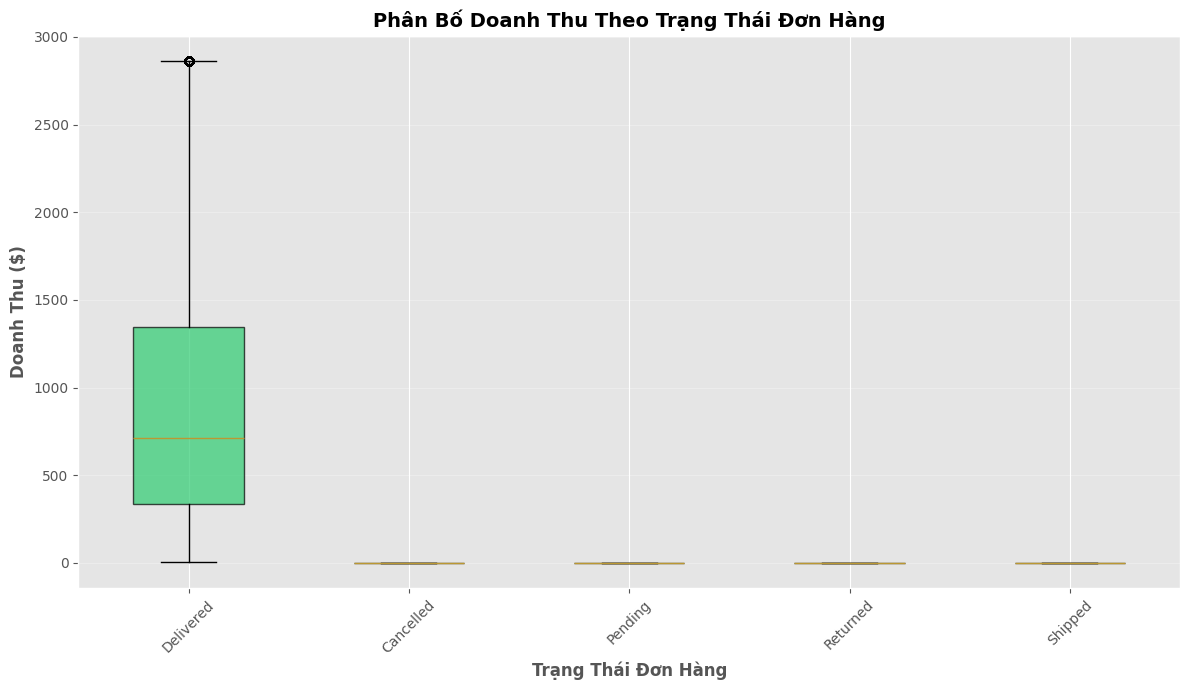

In [150]:
status_order = (
    df.groupby("OrderStatus")["Revenue"].median().sort_values(ascending=False).index
)
df_sorted = df[df["OrderStatus"].isin(status_order)]
df_sorted["OrderStatus"] = pd.Categorical(
    df_sorted["OrderStatus"], categories=status_order, ordered=True
)

fig, ax = plt.subplots(figsize=(12, 7))
bp = ax.boxplot(
    [
        df_sorted[df_sorted["OrderStatus"] == status]["Revenue"].values
        for status in status_order
    ],
    labels=status_order,
    patch_artist=True,
    vert=True,
)

colors_status = [
    (
        "#2ecc71"
        if s == "Delivered"
        else (
            "#f39c12"
            if s == "Shipped"
            else "#e74c3c" if s in ["Cancelled", "Returned"] else "#95a5a6"
        )
    )
    for s in status_order
]
for patch, color in zip(bp["boxes"], colors_status):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_title(
    "Phân Bố Doanh Thu Theo Trạng Thái Đơn Hàng", fontsize=14, fontweight="bold"
)
ax.set_xlabel("Trạng Thái Đơn Hàng", fontweight="bold", fontsize=12)
ax.set_ylabel("Doanh Thu ($)", fontweight="bold", fontsize=12)
ax.tick_params(axis="x", rotation=45)
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

**Nhận xét:**
- So sánh giá trị đơn hàng giữa các trạng thái cho thấy sự khác biệt về giá trị. Đơn hàng "Delivered" thường có giá trị cao hơn, phản ánh chất lượng dịch vụ tốt.
- Đơn hàng bị hủy hoặc trả lại có thể có giá trị thấp hơn hoặc cao hơn tùy thuộc vào lý do (sản phẩm không đúng, giá quá cao, v.v.).
- Phân tích này giúp xác định các vấn đề trong quy trình xử lý đơn hàng và cải thiện chất lượng dịch vụ để giảm tỷ lệ hủy/trả lại.

### Q13: Các biến số có mối tương quan như thế nào với nhau?

Đánh giá mối quan hệ giữa các biến định lượng trong dataset.

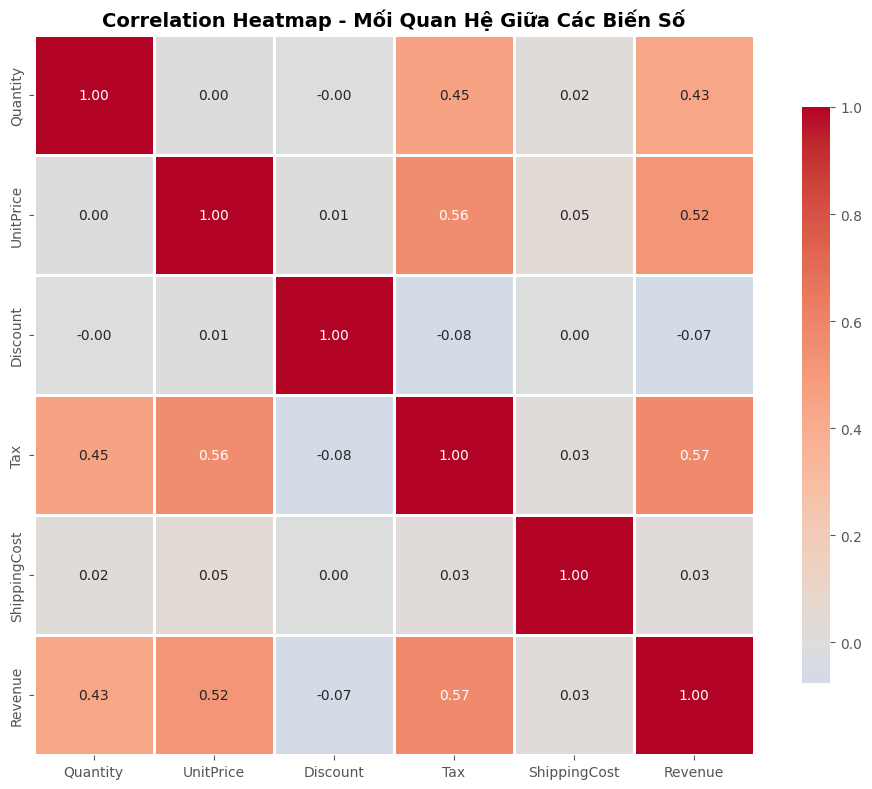

In [151]:
numeric_cols = ['Quantity', 'UnitPrice', 'Discount', 'Tax', 'ShippingCost', 'Revenue']
correlation_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax,
            xticklabels=numeric_cols, yticklabels=numeric_cols)
ax.set_title('Correlation Heatmap - Mối Quan Hệ Giữa Các Biến Số', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

**Nhận xét:**
- Correlation heatmap cho thấy mối quan hệ tuyến tính giữa các biến. Giá trị gần +1 cho thấy tương quan dương mạnh, gần -1 cho thấy tương quan âm mạnh, gần 0 cho thấy không có tương quan.
- Các biến có tương quan cao với Revenue là những biến quan trọng nhất trong việc dự đoán doanh thu.
- Phát hiện multicollinearity (tương quan cao giữa các biến độc lập) giúp tránh vấn đề trong các mô hình dự đoán và cải thiện tính giải thích của mô hình.

### Q14: Bảng phân phối của tổng doanh thu:

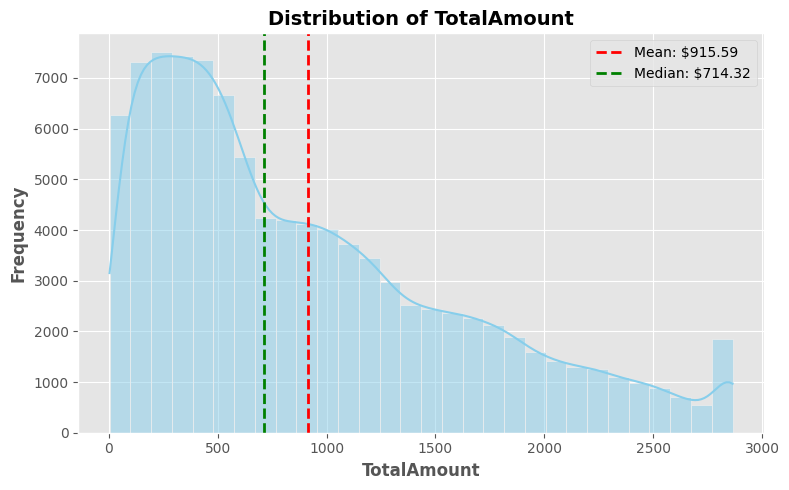

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df["TotalAmount"].dropna(), bins=30, kde=True, color="skyblue")

# Tính mean và median
mean_val = df["TotalAmount"].mean()
median_val = df["TotalAmount"].median()

# Thêm các đường mean và median vào biểu đồ
plt.axvline(
    mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean: ${mean_val:,.2f}"
)
plt.axvline(
    median_val,
    color="green",
    linestyle="--",
    linewidth=2,
    label=f"Median: ${median_val:,.2f}",
)

# Thêm tiêu đề và nhãn
plt.title("Distribution of TotalAmount", fontsize=14, fontweight="bold")
plt.xlabel("TotalAmount", fontsize=12, fontweight="bold")
plt.ylabel("Frequency", fontsize=12, fontweight="bold")
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


**Nhận xét:**

-  Biểu đồ phân phối tổng doanh thu (TotalAmount) cho thấy dữ liệu không tuân theo phân phối chuẩn, có độ lệch phải rõ rệt (right-skewed), với đuôi kéo dài về phía các giá trị doanh thu lớn.

- Giá trị mean ($918.26) lớn hơn median ($714.32), cho thấy tồn tại một số đơn hàng có doanh thu rất cao làm kéo trung bình lên, trong khi phần lớn đơn hàng có doanh thu ở mức trung bình–thấp.

- Phần lớn đơn hàng tập trung trong khoảng doanh thu từ 0 đến 1,000 USD, trong khi các đơn có doanh thu trên 2,000 USD chiếm tỷ lệ nhỏ nhưng có ảnh hưởng đáng kể đến tổng doanh thu.

- Sự chênh lệch giữa mean và median cho thấy việc sử dụng median có thể phản ánh tốt hơn giá trị điển hình của đơn hàng, đặc biệt trong các phân tích so sánh hoặc mô hình dự đoán

## Phần 2: 8 Câu Hỏi EDA Nâng Cao

---

### Q15: Doanh thu tích lũy theo thời gian tăng trưởng như thế nào?

Phân tích xu hướng tăng trưởng doanh thu tích lũy theo thời gian để đánh giá hiệu quả kinh doanh dài hạn.

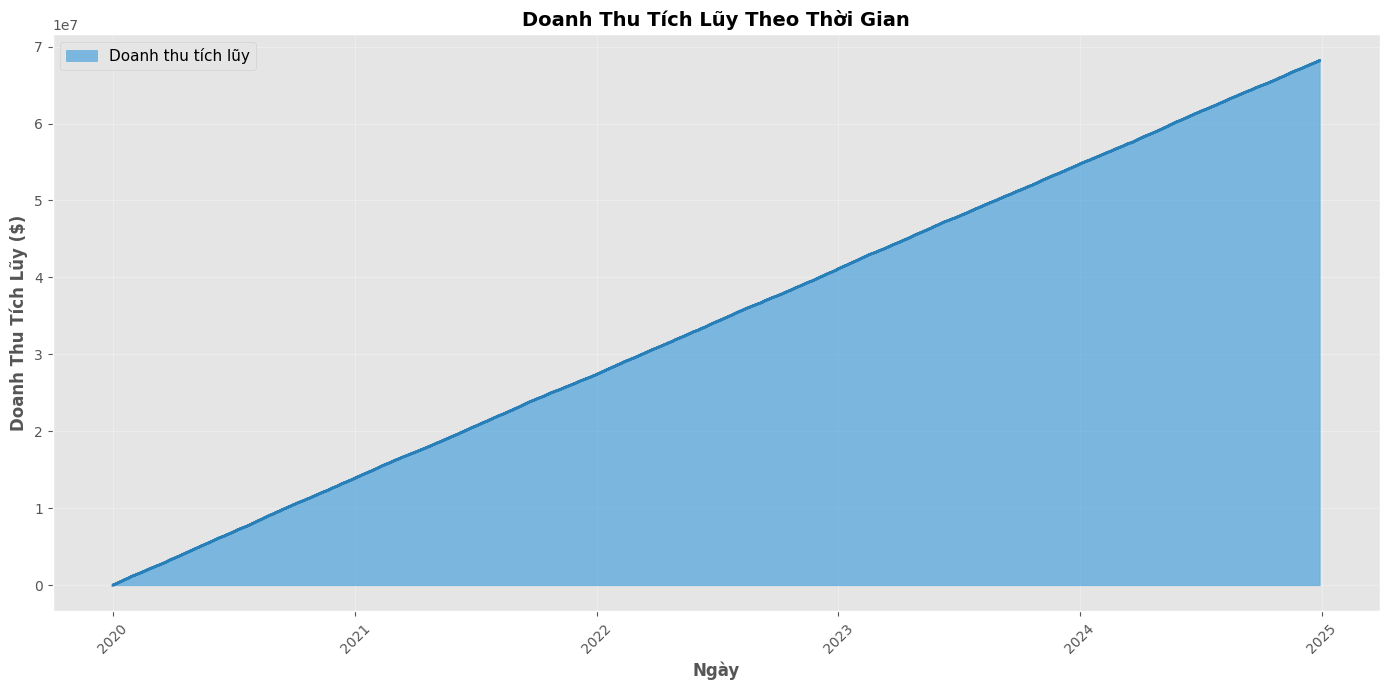

📊 Tổng doanh thu: $68,180,004.27
📈 Tăng trưởng trung bình mỗi tháng: $1,136,333.40


In [153]:
# Tính doanh thu tích lũy theo thời gian
df_sorted = df.sort_values('OrderDate')
df_sorted['CumulativeRevenue'] = df_sorted['Revenue'].cumsum()

fig, ax = plt.subplots(figsize=(14, 7))
ax.fill_between(df_sorted['OrderDate'], df_sorted['CumulativeRevenue'], 
                alpha=0.6, color='#3498db', label='Doanh thu tích lũy')
ax.plot(df_sorted['OrderDate'], df_sorted['CumulativeRevenue'], 
        color='#2980b9', linewidth=2)

ax.set_title('Doanh Thu Tích Lũy Theo Thời Gian', fontweight='bold', fontsize=14)
ax.set_xlabel('Ngày', fontweight='bold', fontsize=12)
ax.set_ylabel('Doanh Thu Tích Lũy ($)', fontweight='bold', fontsize=12)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# In thống kê tăng trưởng
print(f"📊 Tổng doanh thu: ${df_sorted['CumulativeRevenue'].iloc[-1]:,.2f}")
print(f"📈 Tăng trưởng trung bình mỗi tháng: ${(df_sorted['CumulativeRevenue'].iloc[-1] / len(df_sorted['OrderDate'].dt.to_period('M').unique())):,.2f}")

### Q16: Phân khúc thị trường theo danh mục sản phẩm được phân chia như thế nào?

Phân tích thị phần của từng danh mục để hiểu cấu trúc doanh thu và xác định các danh mục chiếm ưu thế.

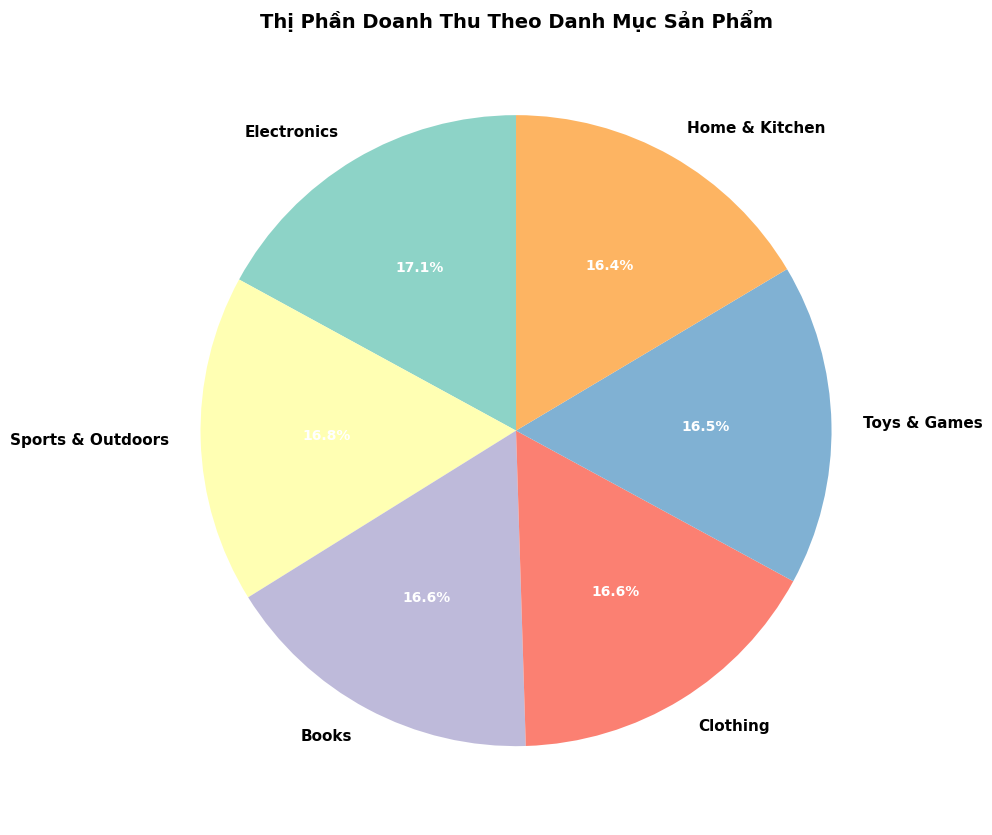

📊 Top 3 danh mục có thị phần lớn nhất:
  1. Electronics: $11,624,851.12 (17.05%)
  2. Sports & Outdoors: $11,461,496.12 (16.81%)
  3. Books: $11,340,468.91 (16.63%)


In [154]:
category_revenue = df.groupby("Category")["Revenue"].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
colors_pie = plt.cm.Set3(range(len(category_revenue)))
wedges, texts, autotexts = ax.pie(
    category_revenue.values,
    labels=category_revenue.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors_pie,
    textprops={"fontsize": 11, "fontweight": "bold"},
)

for autotext in autotexts:
    autotext.set_color("white")
    autotext.set_fontsize(10)
    autotext.set_fontweight("bold")

ax.set_title(
    "Thị Phần Doanh Thu Theo Danh Mục Sản Phẩm", fontweight="bold", fontsize=14
)
plt.tight_layout()
plt.show()

print("📊 Top 3 danh mục có thị phần lớn nhất:")
for i, (cat, rev) in enumerate(category_revenue.head(3).items(), 1):
    pct = (rev / category_revenue.sum()) * 100
    print(f"  {i}. {cat}: ${rev:,.2f} ({pct:.2f}%)")

**Nhận xét:**
- Biểu đồ tròn cho thấy phân bổ thị phần rõ ràng, giúp xác định các danh mục chủ đạo và các danh mục cần phát triển.
- Danh mục có thị phần cao thường là những sản phẩm có nhu cầu lớn hoặc giá trị cao, đóng vai trò quan trọng trong chiến lược kinh doanh.
- Phân tích này hỗ trợ quyết định về việc đầu tư marketing, mở rộng sản phẩm, hoặc đa dạng hóa danh mục để cân bằng rủi ro.

### Q17: Tên sản phẩm và thương hiệu nào xuất hiện nhiều nhất trong đơn hàng?

Phân tích từ khóa phổ biến từ tên sản phẩm và thương hiệu bằng word cloud để xác định xu hướng và sở thích khách hàng.

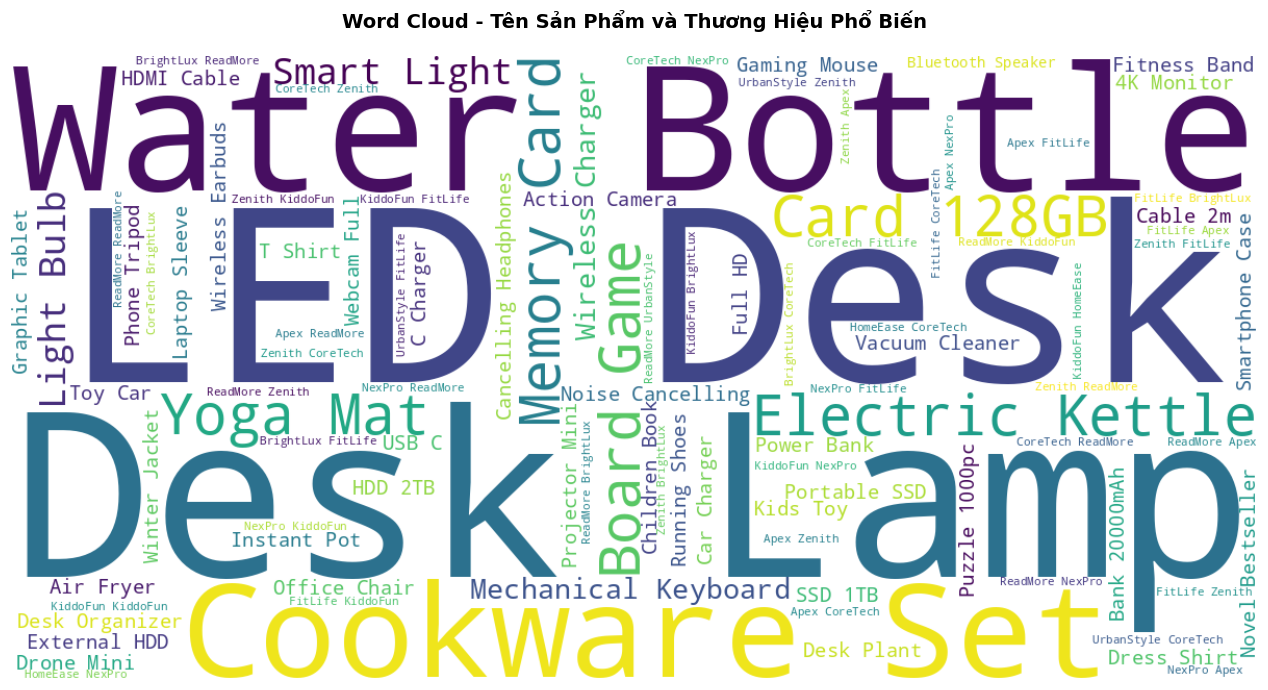

📊 Top 10 thương hiệu có số đơn hàng nhiều nhất:
  1. ReadMore: 10,204 đơn hàng
  2. FitLife: 10,147 đơn hàng
  3. CoreTech: 10,127 đơn hàng
  4. KiddoFun: 10,077 đơn hàng
  5. Zenith: 9,990 đơn hàng
  6. NexPro: 9,962 đơn hàng
  7. Apex: 9,937 đơn hàng
  8. BrightLux: 9,907 đơn hàng
  9. UrbanStyle: 9,854 đơn hàng
  10. HomeEase: 9,795 đơn hàng


In [155]:
# Kết hợp tên sản phẩm và thương hiệu
product_text = " ".join(df["ProductName"].astype(str).dropna())
brand_text = " ".join(df["Brand"].astype(str).dropna())
combined_text = product_text + " " + brand_text

# Tạo word cloud
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    colormap="viridis",
    max_words=100,
    relative_scaling=0.5,
).generate(combined_text)

fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
ax.set_title(
    "Word Cloud - Tên Sản Phẩm và Thương Hiệu Phổ Biến",
    fontweight="bold",
    fontsize=14,
    pad=20,
)
plt.tight_layout()
plt.show()

# Top 10 thương hiệu phổ biến nhất
print("📊 Top 10 thương hiệu có số đơn hàng nhiều nhất:")
top_brands = df["Brand"].value_counts().head(10)
for i, (brand, count) in enumerate(top_brands.items(), 1):
    print(f"  {i}. {brand}: {count:,} đơn hàng")

**Nhận xét:**
- Word cloud giúp nhận diện nhanh các từ khóa, tên sản phẩm và thương hiệu xuất hiện nhiều nhất, phản ánh xu hướng thị trường.
- Các từ khóa có kích thước lớn cho thấy mức độ phổ biến cao, có thể là điểm mạnh của doanh nghiệp hoặc cơ hội để tối ưu hóa.
- Phân tích này hỗ trợ chiến lược marketing, định vị sản phẩm, và xác định các thương hiệu đối tác tiềm năng.

### Q18: Phân phối giá sản phẩm giữa các danh mục có khác biệt như thế nào?

Sử dụng violin plot để so sánh chi tiết phân phối giá cả giữa các danh mục, bao gồm cả mật độ phân phối.

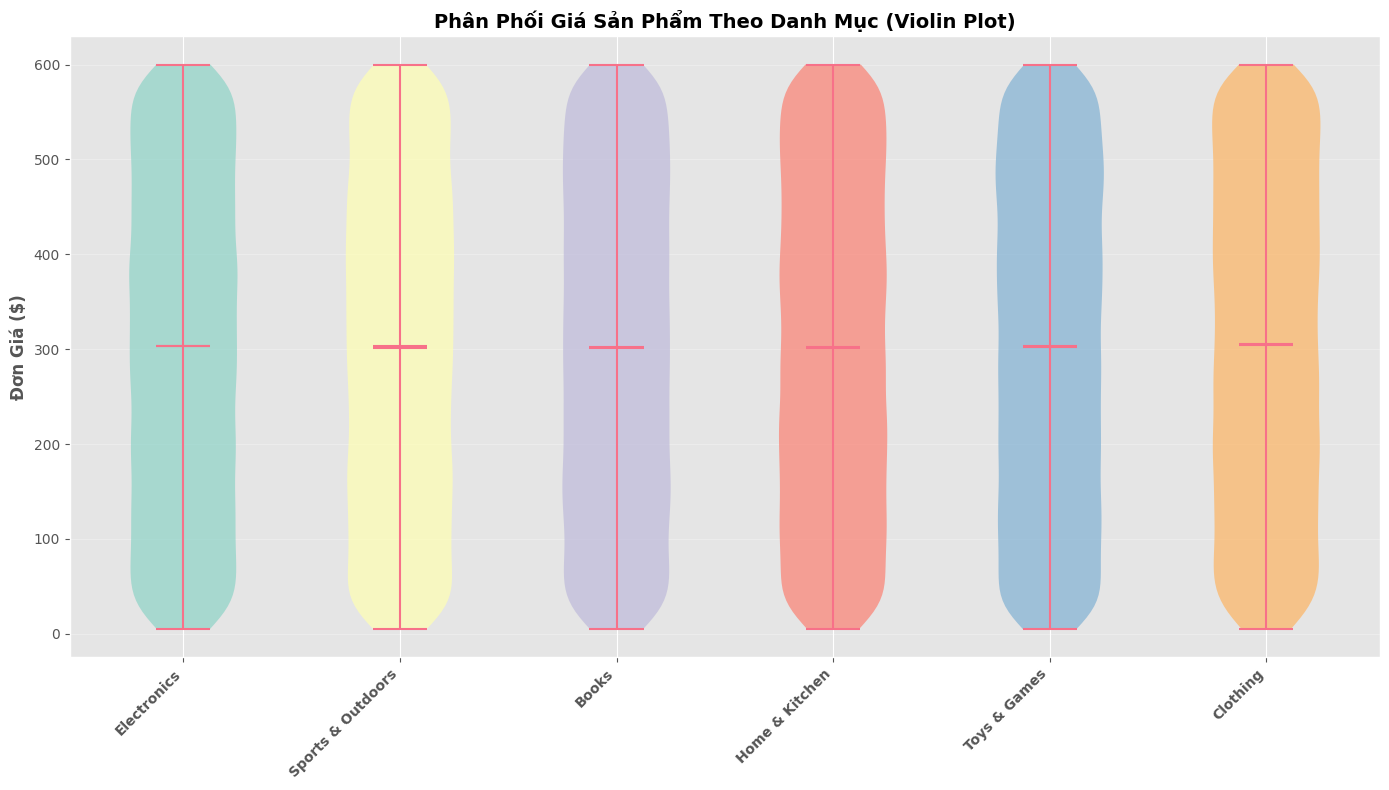

📊 Giá trung bình theo danh mục:
  Electronics: Trung bình $302.93, Median $303.48
  Sports & Outdoors: Trung bình $301.76, Median $303.08
  Books: Trung bình $302.02, Median $301.39
  Home & Kitchen: Trung bình $302.76, Median $301.19
  Toys & Games: Trung bình $302.81, Median $303.70


In [156]:
top_categories = df['Category'].value_counts().head(8).index
df_top_cat = df[df['Category'].isin(top_categories)]

fig, ax = plt.subplots(figsize=(14, 8))
violin_parts = ax.violinplot([df_top_cat[df_top_cat['Category']==cat]['UnitPrice'].values 
                               for cat in top_categories],
                             positions=range(len(top_categories)), 
                             showmeans=True, showmedians=True)

# Tùy chỉnh màu sắc
colors_violin = plt.cm.Set3(range(len(top_categories)))
for pc, color in zip(violin_parts['bodies'], colors_violin):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

ax.set_xticks(range(len(top_categories)))
ax.set_xticklabels(top_categories, rotation=45, ha='right', fontweight='bold', fontsize=10)
ax.set_ylabel('Đơn Giá ($)', fontweight='bold', fontsize=12)
ax.set_title('Phân Phối Giá Sản Phẩm Theo Danh Mục (Violin Plot)', 
             fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Thống kê giá trung bình
print("📊 Giá trung bình theo danh mục:")
for cat in top_categories[:5]:
    avg_price = df_top_cat[df_top_cat['Category']==cat]['UnitPrice'].mean()
    median_price = df_top_cat[df_top_cat['Category']==cat]['UnitPrice'].median()
    print(f"  {cat}: Trung bình ${avg_price:.2f}, Median ${median_price:.2f}")

**Nhận xét:**
- Violin plot kết hợp box plot và density plot, cho thấy cả phân phối và mật độ giá cả, giúp phát hiện các pattern phức tạp.
- Phần rộng của violin cho thấy mật độ cao ở mức giá đó, phần hẹp cho thấy ít sản phẩm ở mức giá tương ứng.
- So sánh giữa các danh mục giúp xác định danh mục có giá cao/thấp, độ biến động giá, và các danh mục có phân phối giá đa dạng hay tập trung.

### Q19: Xu hướng doanh thu theo từng danh mục thay đổi như thế nào theo thời gian?

Phân tích stacked area chart để xem sự đóng góp của từng danh mục vào tổng doanh thu theo thời gian.

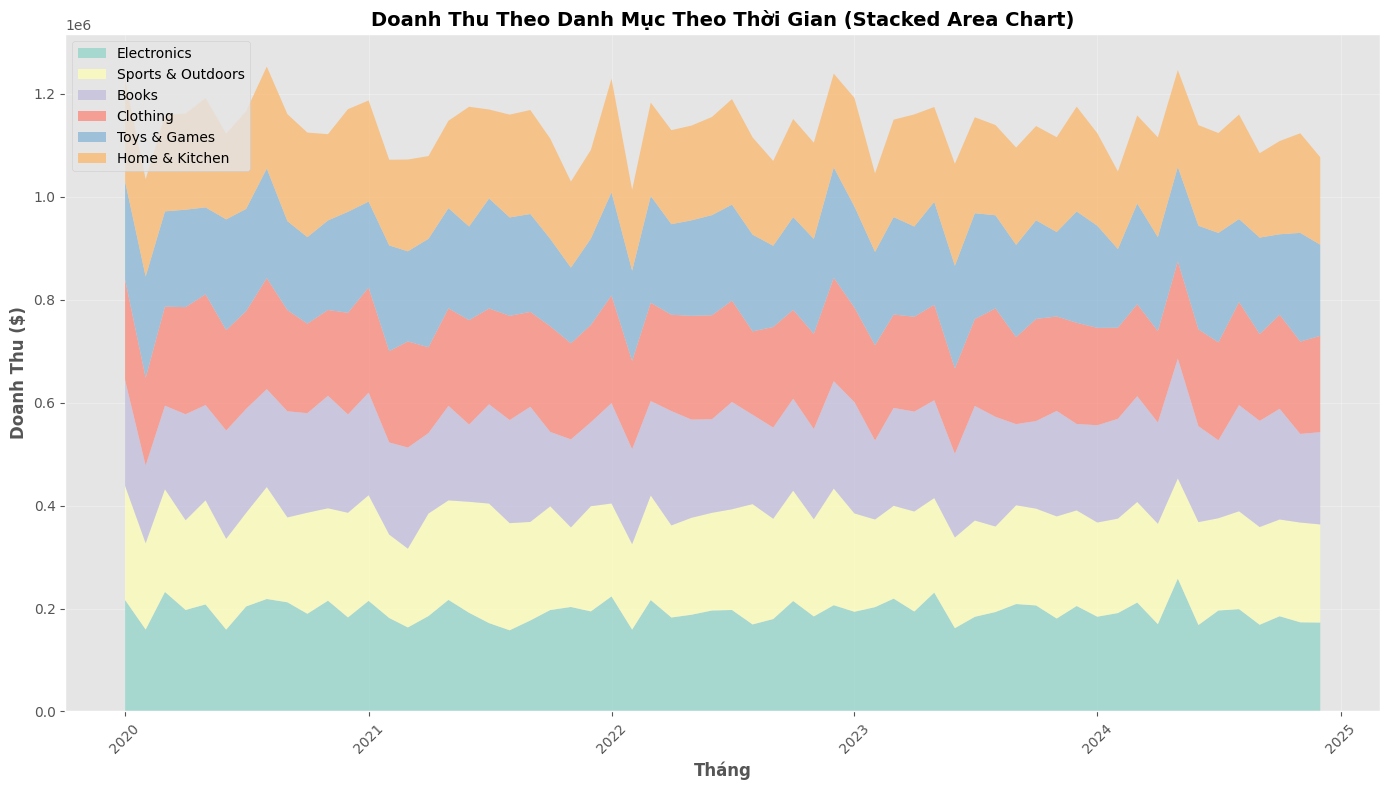

📊 Doanh thu tổng theo danh mục (Top 6):
  Electronics: $11,624,851.12 (17.1%)
  Sports & Outdoors: $11,461,496.12 (16.8%)
  Books: $11,340,468.91 (16.6%)
  Clothing: $11,307,502.60 (16.6%)
  Toys & Games: $11,232,094.45 (16.5%)
  Home & Kitchen: $11,213,591.06 (16.4%)


In [157]:
# Tính doanh thu theo tháng và danh mục
monthly_category = (
    df.groupby([df["OrderDate"].dt.to_period("M"), "Category"])["Revenue"]
    .sum()
    .unstack(fill_value=0)
)
monthly_category.index = monthly_category.index.to_timestamp()

# Chọn top 6 danh mục
top_cats = monthly_category.sum().nlargest(6).index
monthly_category_top = monthly_category[top_cats]

fig, ax = plt.subplots(figsize=(14, 8))
ax.stackplot(
    monthly_category_top.index,
    *[monthly_category_top[cat] for cat in top_cats],
    labels=top_cats,
    alpha=0.7,
    colors=plt.cm.Set3(range(len(top_cats))),
)

ax.set_title(
    "Doanh Thu Theo Danh Mục Theo Thời Gian (Stacked Area Chart)",
    fontweight="bold",
    fontsize=14,
)
ax.set_xlabel("Tháng", fontweight="bold", fontsize=12)
ax.set_ylabel("Doanh Thu ($)", fontweight="bold", fontsize=12)
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("📊 Doanh thu tổng theo danh mục (Top 6):")
for cat in top_cats:
    total_rev = monthly_category_top[cat].sum()
    pct = (total_rev / monthly_category_top.sum().sum()) * 100
    print(f"  {cat}: ${total_rev:,.2f} ({pct:.1f}%)")

**Nhận xét:**
- Stacked area chart cho thấy cả tổng doanh thu và đóng góp của từng danh mục, giúp nhận diện xu hướng theo thời gian.
- Danh mục có diện tích lớn đóng góp nhiều vào tổng doanh thu, trong khi các danh mục có diện tích nhỏ có thể cần chiến lược phát triển.
- Phân tích theo thời gian giúp phát hiện tính mùa vụ, xu hướng tăng/giảm của từng danh mục, và các điểm bất thường cần điều tra.

### Q20: Có mối quan hệ phức tạp nào giữa Discount, Quantity và Revenue không?

Phân tích 3D scatter plot để khám phá mối quan hệ đa chiều giữa các biến quan trọng.

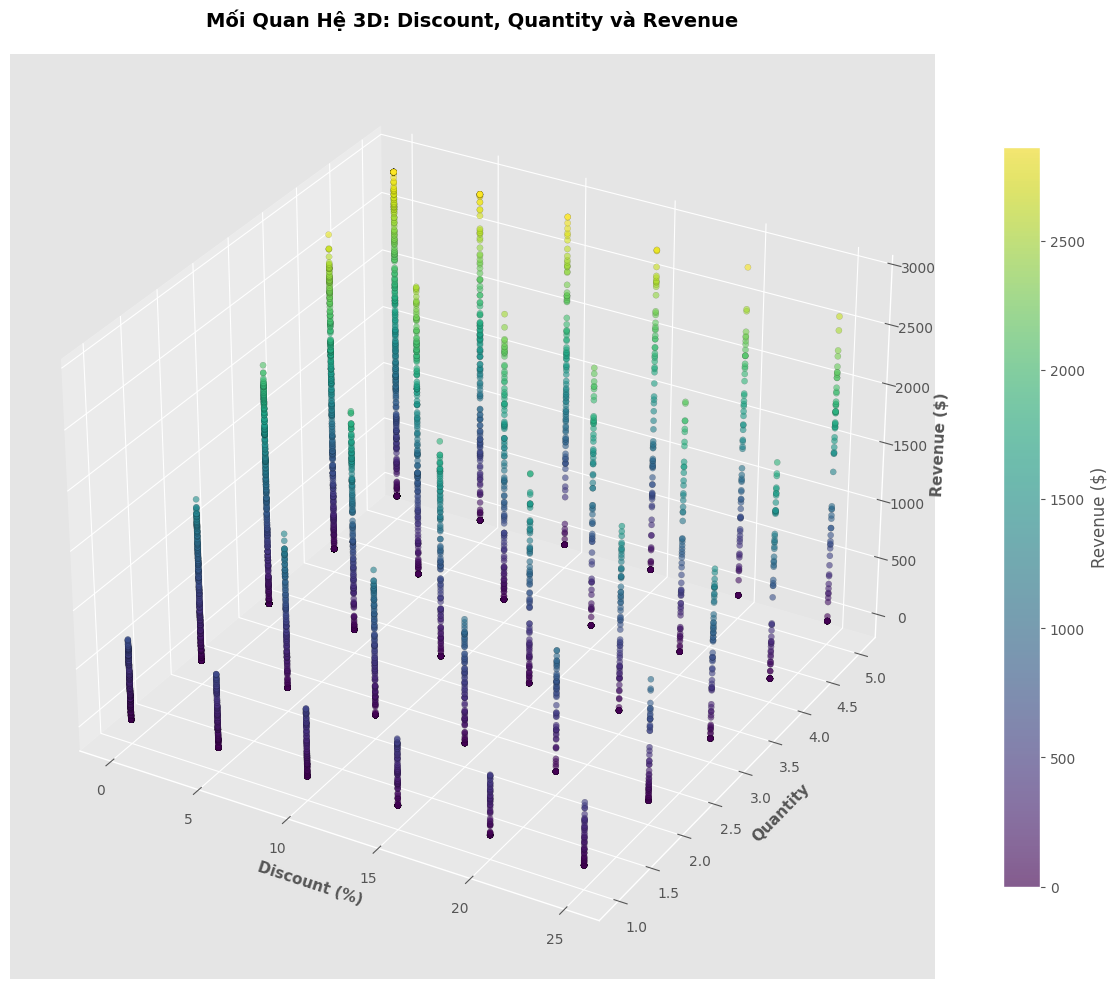

📊 Correlation matrix:
          Discount  Quantity  Revenue
Discount      1.00      0.01    -0.08
Quantity      0.01      1.00     0.43
Revenue      -0.08      0.43     1.00


In [158]:
# Lấy mẫu ngẫu nhiên để tránh quá tải
df_sample = df.sample(n=min(5000, len(df)), random_state=42)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_sample['Discount']*100, df_sample['Quantity'], 
                    df_sample['Revenue'], 
                    c=df_sample['Revenue'], cmap='viridis', 
                    alpha=0.6, s=20, edgecolors='black', linewidth=0.1)

ax.set_xlabel('Discount (%)', fontweight='bold', fontsize=11)
ax.set_ylabel('Quantity', fontweight='bold', fontsize=11)
ax.set_zlabel('Revenue ($)', fontweight='bold', fontsize=11)
ax.set_title('Mối Quan Hệ 3D: Discount, Quantity và Revenue', 
             fontweight='bold', fontsize=14, pad=20)

plt.colorbar(scatter, ax=ax, label='Revenue ($)', shrink=0.8)
plt.tight_layout()
plt.show()

# Tính correlation matrix
corr_vars = df_sample[['Discount', 'Quantity', 'Revenue']].corr()
print("📊 Correlation matrix:")
print(corr_vars.round(3))

**Nhận xét:**
- 3D scatter plot cho phép quan sát mối quan hệ đồng thời giữa 3 biến, phát hiện các pattern phức tạp không thể thấy trong 2D.
- Màu sắc điểm dữ liệu dựa trên Revenue giúp xác định các kết hợp Discount-Quantity tạo ra doanh thu cao nhất.
- Phân tích này hỗ trợ xác định chiến lược pricing và promotion tối ưu, ví dụ: mức discount nào kết hợp với số lượng nào sẽ tối đa hóa doanh thu.

### Q21: Làm thế nào để so sánh hiệu suất đa chiều của các danh mục sản phẩm?

Sử dụng radar chart để so sánh đồng thời nhiều chỉ số (revenue, quantity, average price, order count) của các danh mục.

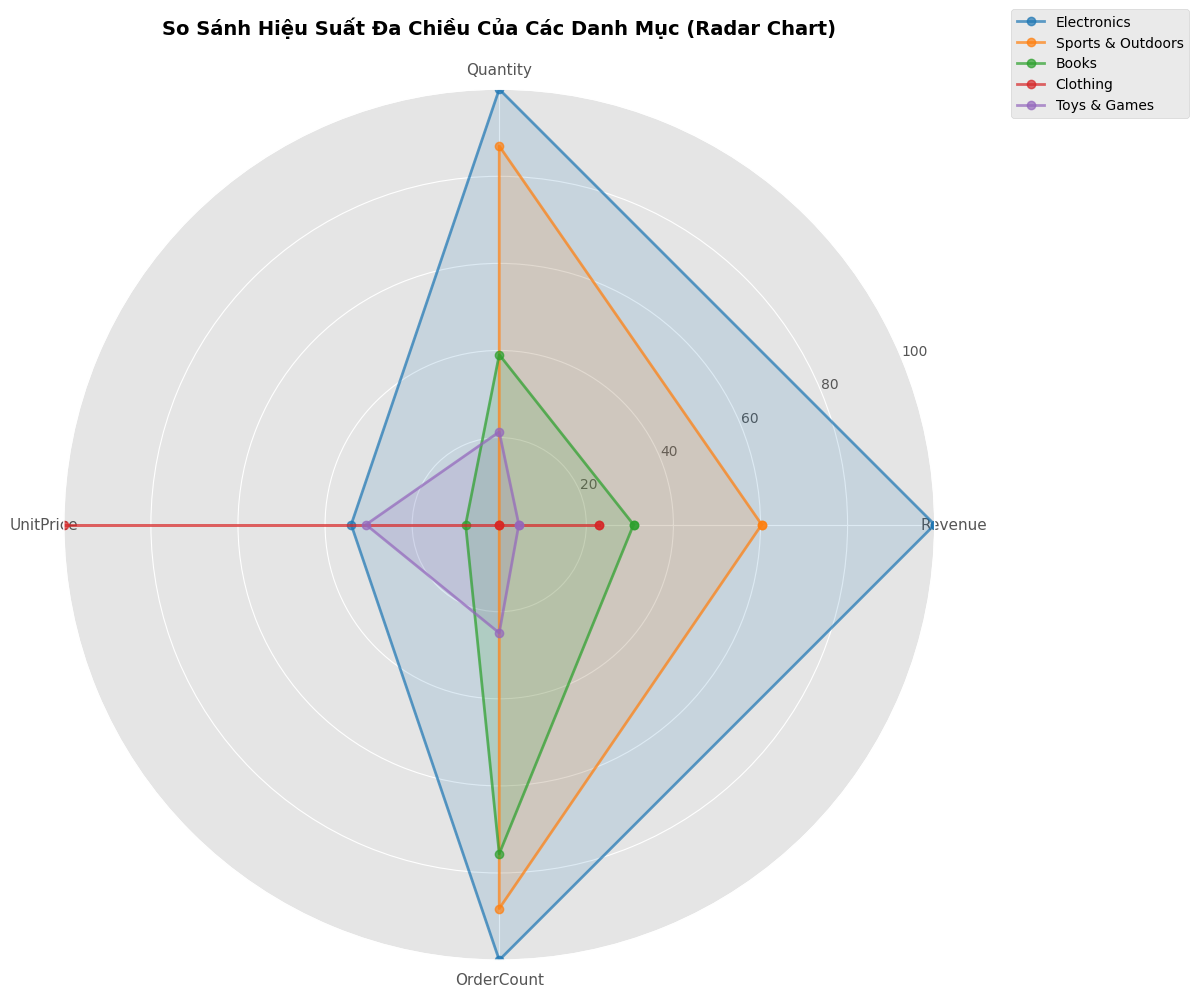

📊 Top 5 danh mục theo doanh thu:
  1. Electronics: $11,624,851.12
  2. Sports & Outdoors: $11,461,496.12
  3. Books: $11,340,468.91
  4. Clothing: $11,307,502.61
  5. Toys & Games: $11,232,094.45


In [159]:
import numpy as np

# Tính các metrics cho từng danh mục
category_metrics = (
    df.groupby("Category")
    .agg({"Revenue": "sum", "Quantity": "sum", "UnitPrice": "mean", "OrderID": "count"})
    .rename(columns={"OrderID": "OrderCount"})
)

# Chuẩn hóa về thang 0-100 để so sánh
scaler = MinMaxScaler(feature_range=(0, 100))
category_normalized = pd.DataFrame(
    scaler.fit_transform(category_metrics),
    index=category_metrics.index,
    columns=category_metrics.columns,
)

# Chọn top 5 danh mục
top_5_cats = category_metrics["Revenue"].nlargest(5).index

# Tạo radar chart
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection="polar"))
angles = np.linspace(
    0, 2 * np.pi, len(category_normalized.columns), endpoint=False
).tolist()
angles += angles[:1]  # Đóng vòng tròn

colors = plt.cm.tab10(range(len(top_5_cats)))
for idx, cat in enumerate(top_5_cats):
    values = category_normalized.loc[cat].values.tolist()
    values += values[:1]
    ax.plot(angles, values, "o-", linewidth=2, label=cat, color=colors[idx], alpha=0.7)
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(category_normalized.columns, fontsize=11)
ax.set_ylim(0, 100)
ax.set_title(
    "So Sánh Hiệu Suất Đa Chiều Của Các Danh Mục (Radar Chart)",
    fontweight="bold",
    fontsize=14,
    pad=20,
)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.grid(True)

plt.tight_layout()
plt.show()

print("📊 Top 5 danh mục theo doanh thu:")
for i, cat in enumerate(top_5_cats, 1):
    print(f"  {i}. {cat}: ${category_metrics.loc[cat, 'Revenue']:,.2f}")

**Nhận xét:**
- Radar chart cho phép so sánh đồng thời nhiều chỉ số, giúp đánh giá toàn diện hiệu suất của từng danh mục.
- Danh mục có diện tích lớn trên radar chart thường có hiệu suất tốt trên nhiều mặt, trong khi danh mục có hình dạng không đều cho thấy điểm mạnh/yếu riêng biệt.
- Phân tích này hỗ trợ xác định danh mục cần đầu tư phát triển, danh mục cần cải thiện, và các chỉ số cụ thể cần tập trung để tối ưu hóa hiệu suất.

### Q22: Cấu trúc phân cấp doanh thu theo danh mục và thương hiệu được thể hiện như thế nào?

Sử dụng treemap để hiển thị cấu trúc phân cấp doanh thu, giúp xác định danh mục và thương hiệu đóng góp nhiều nhất.

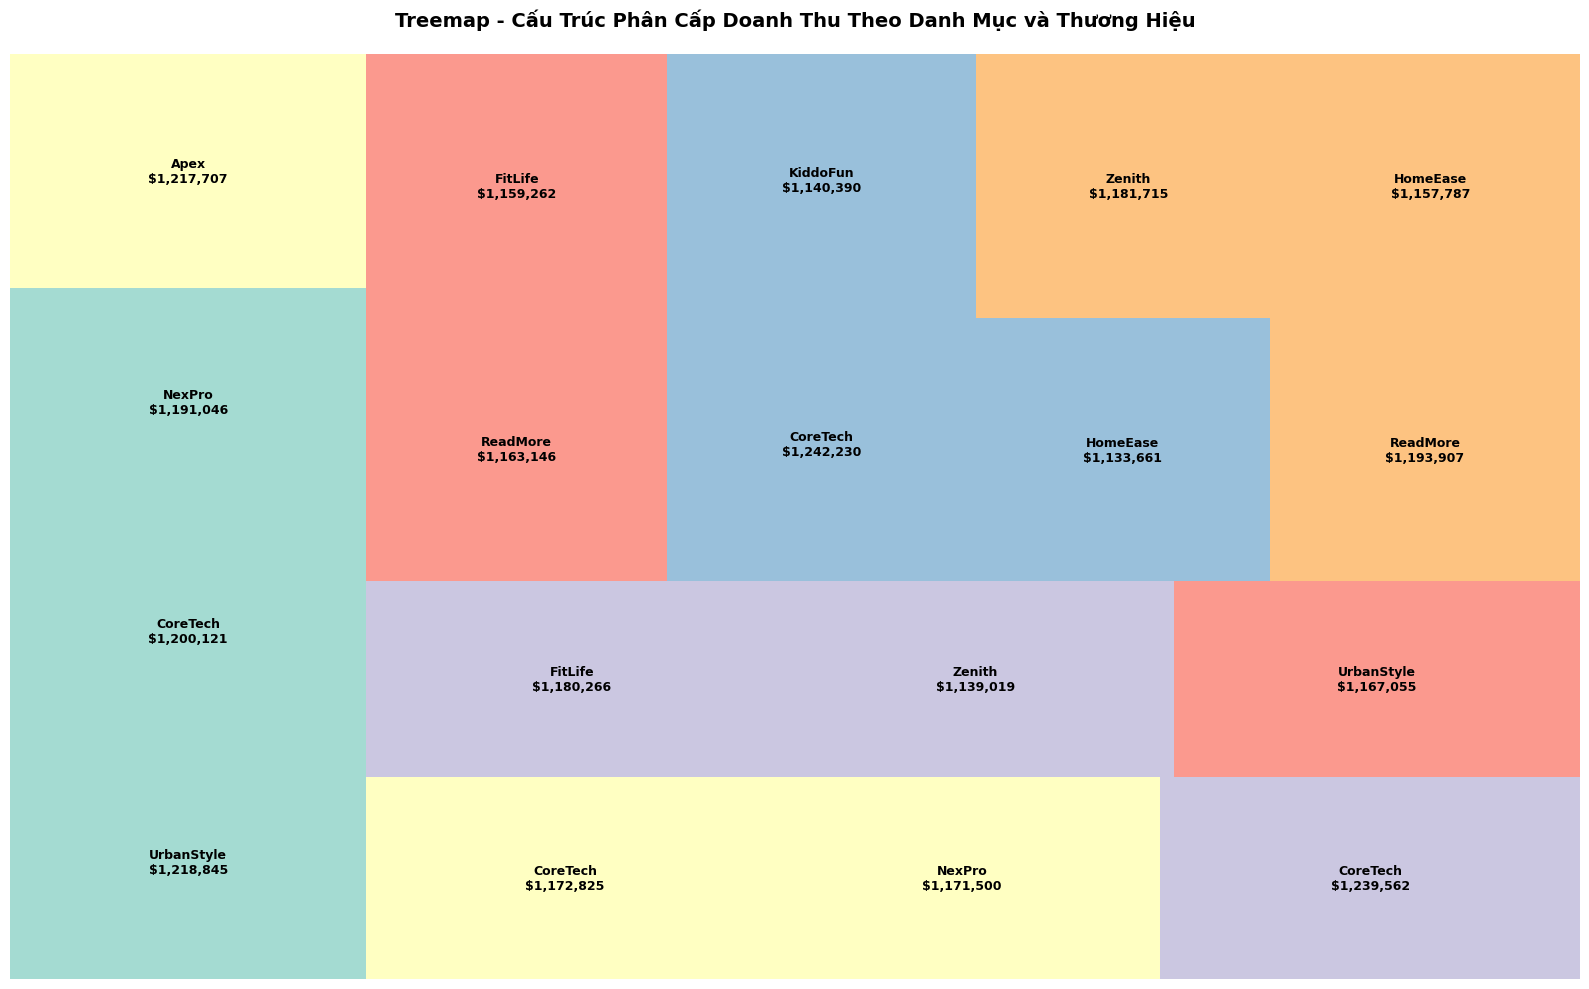

Top 5 cặp Category-Brand có doanh thu cao nhất:
  1. Toys & Games - CoreTech: $1,242,230.21
  2. Books - CoreTech: $1,239,561.93
  3. Electronics - UrbanStyle: $1,218,845.10
  4. Sports & Outdoors - Apex: $1,217,706.60
  5. Electronics - CoreTech: $1,200,120.81


In [160]:
# Tính doanh thu theo danh mục và thương hiệu
category_brand_revenue = df.groupby(['Category', 'Brand'])['Revenue'].sum().reset_index()
category_brand_revenue = category_brand_revenue.sort_values('Revenue', ascending=False)

# Chọn top categories và brands
top_categories = category_brand_revenue.groupby('Category')['Revenue'].sum().nlargest(8).index
top_brands_per_cat = category_brand_revenue[category_brand_revenue['Category'].isin(top_categories)].groupby('Category').head(3)

# Tạo treemap
fig, ax = plt.subplots(figsize=(16, 10))

# Tạo labels và sizes
labels = []
sizes = []
colors_treemap = []
colors_list = plt.cm.Set3(range(len(top_categories)))

for idx, cat in enumerate(top_categories):
    cat_data = top_brands_per_cat[top_brands_per_cat['Category']==cat]
    for _, row in cat_data.iterrows():
        labels.append(f"{row['Brand']}\n${row['Revenue']:,.0f}")
        sizes.append(row['Revenue'])
        colors_treemap.append(colors_list[idx])

squarify.plot(sizes=sizes, label=labels, alpha=0.8, 
              color=colors_treemap, text_kwargs={'fontsize': 9, 'fontweight': 'bold'})

ax.set_title('Treemap - Cấu Trúc Phân Cấp Doanh Thu Theo Danh Mục và Thương Hiệu', 
             fontweight='bold', fontsize=14, pad=20)
ax.axis('off')
plt.tight_layout()
plt.show()

print("Top 5 cặp Category-Brand có doanh thu cao nhất:")
for i, (_, row) in enumerate(category_brand_revenue.head(5).iterrows(), 1):
    print(f"  {i}. {row['Category']} - {row['Brand']}: ${row['Revenue']:,.2f}")

**Nhận xét:**
- Treemap hiển thị cấu trúc phân cấp dữ liệu một cách trực quan, diện tích mỗi hình chữ nhật tỷ lệ với giá trị doanh thu.
- Dễ dàng xác định danh mục và thương hiệu đóng góp nhiều nhất vào tổng doanh thu, hỗ trợ quyết định tập trung nguồn lực.
- Phân tích này giúp phát hiện các cơ hội phát triển (thương hiệu có tiềm năng trong danh mục), các rủi ro (phụ thuộc quá nhiều vào một thương hiệu), và chiến lược đa dạng hóa.

### Q23: Doanh thu phân bố như thế nào giữa các quốc gia trên thế giới?

Sử dụng Choropleth Map để hiển thị phân bố doanh thu theo quốc gia, giúp xác định các thị trường quan trọng và tiềm năng phát triển. Liệu doanh thu có bị ảnh hưởn bới khu vực tức là ở các thành phố lớn hay ở các nước phát triển sẽ có trọng số trong doanh thu lớn hơn không

In [161]:

countries = df['Country'].unique()
states = df['State'].unique()

print(f"📍 Số lượng quốc gia: {len(countries)}")
print(f"Các quốc gia: {', '.join(sorted(countries))}")
print(f"\n📍 Số lượng bang/tiểu bang: {len(states)}")
print(f"Các bang/tiểu bang: {', '.join(sorted(states))}")

# Thống kê số lượng đơn hàng và doanh thu theo quốc gia
country_stats = df.groupby('Country').agg({
    'OrderID': 'count',
    'Revenue': 'sum'
}).rename(columns={'OrderID': 'Orders'})
country_stats['Revenue'] = country_stats['Revenue'].round(2)
country_stats = country_stats.sort_values('Revenue', ascending=False)

print("\n📊 Thống kê theo quốc gia:")
print(country_stats)

📍 Số lượng quốc gia: 5
Các quốc gia: Australia, Canada, India, United Kingdom, United States

📍 Số lượng bang/tiểu bang: 13
Các bang/tiểu bang: AZ, CA, CO, DC, FL, IL, IN, NC, NY, OH, PA, TX, WA

📊 Thống kê theo quốc gia:
                Orders     Revenue
Country                           
United States    70058 47801559.18
India            15051 10349570.67
Canada            5818  3914475.77
United Kingdom    4943  3309317.30
Australia         4130  2805081.35


### Q24: Liệu shipping cost có ảnh hưởng đến trạng thái đơn hàng không?

Trung bình ShippingCost theo OrderStatus:
OrderStatus
Cancelled   7.40
Delivered   7.40
Pending     7.41
Returned    7.43
Shipped     7.41
Name: ShippingCost, dtype: float64
So sánh số lượng đơn hàng theo ShipGroup và OrderStatus:
OrderStatus  Cancelled  Delivered  Pending  Returned  Shipped
ShipGroup                                                    
Low                770      18629     1047       745     3841
Medium             749      18833      981       750     3700
High               735      18574     1057       813     3832
Very High          774      18592     1018       741     3819


/tmp/ipykernel_362410/2887628188.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["ShipGroup", "OrderStatus"]).size().unstack(fill_value=0)


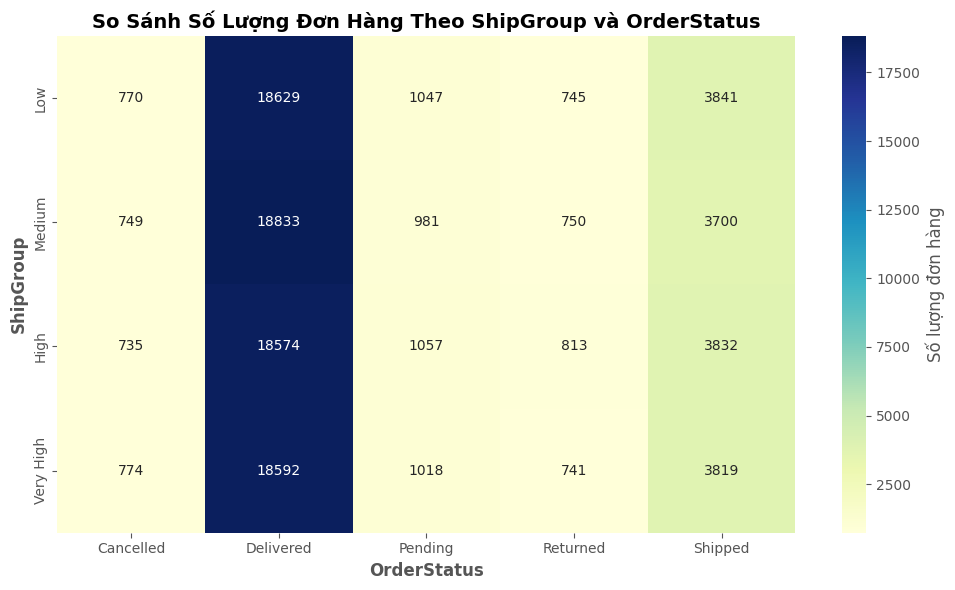

In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1) Trung bình ShippingCost theo OrderStatus
shipping_cost_mean = df.groupby("OrderStatus")["ShippingCost"].mean()
print("Trung bình ShippingCost theo OrderStatus:")
print(shipping_cost_mean)

# 2) Tạo nhóm ShipGroup (an toàn với missing / ít unique values)
shipping = df["ShippingCost"]

# Nếu có missing, giữ nguyên nhưng báo cáo
if shipping.isnull().any():
    print(f"Cảnh báo: {shipping.isnull().sum()} giá trị ShippingCost bị thiếu.")

labels = ["Low", "Medium", "High", "Very High"]
try:
    # Thử qcut trước (chia theo phân vị)
    df["ShipGroup"] = pd.qcut(shipping, q=4, labels=labels)
except Exception:
    # Nếu qcut lỗi (ví dụ quá ít giá trị khác nhau), dùng cut theo bins đều
    df["ShipGroup"] = pd.cut(shipping, bins=4, labels=labels)

# Nếu vẫn có NaN do giá trị thiếu, thêm category 'Unknown' và điền
if df["ShipGroup"].isnull().any():
    df["ShipGroup"] = df["ShipGroup"].astype("category")
    if "Unknown" not in df["ShipGroup"].cat.categories:
        df["ShipGroup"] = df["ShipGroup"].cat.add_categories(["Unknown"])
    df["ShipGroup"] = df["ShipGroup"].fillna("Unknown")

# Đảm bảo thứ tự hợp lý cho hiển thị
ordered_cats = ["Low", "Medium", "High", "Very High", "Unknown"]
df["ShipGroup"] = pd.Categorical(
    df["ShipGroup"],
    categories=[c for c in ordered_cats if c in df["ShipGroup"].cat.categories],
    ordered=True,
)

# 3) Bảng so sánh và in ra
shipgroup_orderstatus = (
    df.groupby(["ShipGroup", "OrderStatus"]).size().unstack(fill_value=0)
)
print("So sánh số lượng đơn hàng theo ShipGroup và OrderStatus:")
print(shipgroup_orderstatus)

# 4) Vẽ heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    shipgroup_orderstatus,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    cbar_kws={"label": "Số lượng đơn hàng"},
)
plt.title(
    "So Sánh Số Lượng Đơn Hàng Theo ShipGroup và OrderStatus",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("OrderStatus", fontsize=12, fontweight="bold")
plt.ylabel("ShipGroup", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

**Nhận xét:**
- Kết quả cho thấy chi phí vận chuyển trung bình (ShippingCost) giữa các trạng thái đơn hàng gần như không có sự khác biệt đáng kể, với giá trị dao động rất nhỏ quanh mức 7.40 – 7.43 USD cho tất cả các trạng thái Cancelled, Delivered, Pending, Returned và Shipped. Điều này cho thấy chi phí vận chuyển trung bình không phải là yếu tố phân biệt rõ ràng giữa các trạng thái đơn hàng.

- Biểu đồ heatmap so sánh số lượng đơn hàng theo ShipGroup và OrderStatus cho thấy phần lớn đơn hàng ở tất cả các nhóm chi phí vận chuyển đều có trạng thái Delivered, chiếm tỷ trọng áp đảo so với các trạng thái còn lại.

- Số lượng đơn hàng bị Cancelled và Returned tương đối đồng đều giữa các nhóm chi phí vận chuyển, không có xu hướng tăng rõ rệt ở nhóm High hoặc Very High. Điều này cho thấy chi phí vận chuyển cao không làm gia tăng đáng kể tỷ lệ huỷ hoặc trả đơn trong bộ dữ liệu này.

- Trạng thái Shipped cũng phân bố khá tương đồng giữa các ShipGroup, cho thấy tiến trình xử lý đơn hàng không bị ảnh hưởng nhiều bởi mức phí vận chuyển.

- Tổng hợp các kết quả trên cho thấy ShippingCost không phải là yếu tố chính ảnh hưởng đến trạng thái đơn hàng.

## Q25: Tỉ lệ doanh thu giữa nhóm khách chi mua một lần và nhóm khách hàng quay trở lại 

Số lượng khách hàng theo loại:
Customer_type
Khách mua nhiều lần    57956
Khách mua 1 lần        16672
Name: count, dtype: int64
Phân tích doanh thu theo loại khách hàng:
                        Revenue  Share (%)
Customer_type                             
Khách mua 1 lần     15221824.06      22.33
Khách mua nhiều lần 52958180.21      77.67


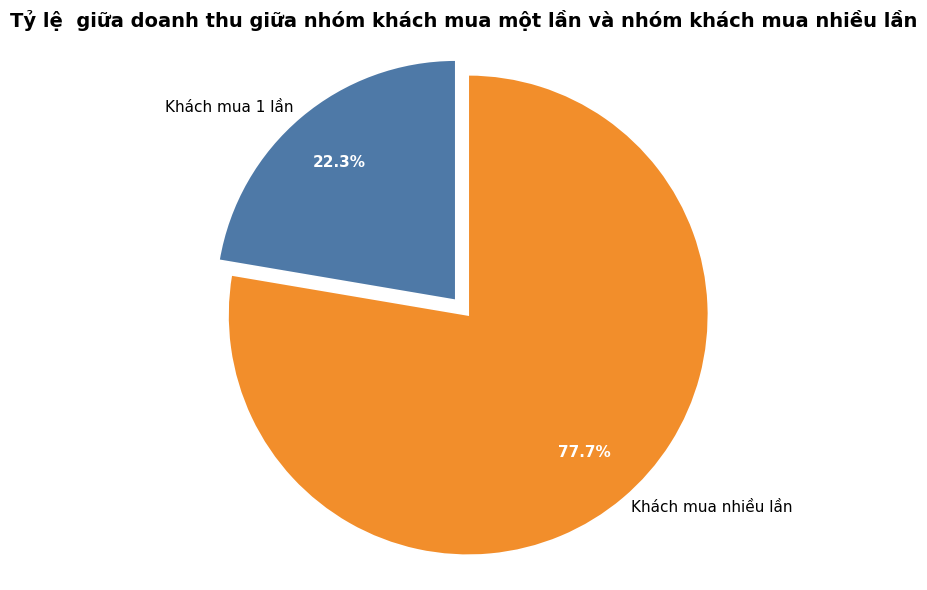

In [163]:
# Phân tích doanh thu và tỷ lệ doanh thu của khách hàng theo loại
import pandas as pd
import matplotlib.pyplot as plt

# Lấy số đơn đã giao theo khách hàng
orders_per_customer = df[df['OrderStatus'] == 'Delivered'].groupby('CustomerID')['OrderID'].nunique()

def categorize_customer(n: int) -> str:
    return 'Khách mua 1 lần' if n == 1 else 'Khách mua nhiều lần'

customer_type = orders_per_customer.map(categorize_customer)

# Gán nhãn phân khúc cho cả df và df_deli (tránh KeyError)
df['Customer_type'] = df['CustomerID'].map(customer_type)

# Tạo df_deli sau khi gán nhãn để đảm bảo có cột Customer_type
df_deli = df[df['OrderStatus'] == 'Delivered'].copy()

# Đếm số lượng khách hàng theo loại
customer_type_counts = df_deli['Customer_type'].value_counts()
print("Số lượng khách hàng theo loại:")
print(customer_type_counts)

# Tính doanh thu và tỷ lệ doanh thu theo loại khách hàng
customer_revenue = df_deli.groupby('Customer_type')['TotalAmount'].sum()
share = (customer_revenue / customer_revenue.sum() * 100).round(2)

customer_analysis = pd.DataFrame({'Revenue': customer_revenue.round(2), 'Share (%)': share})
print("Phân tích doanh thu theo loại khách hàng:")
print(customer_analysis)

fig, ax = plt.subplots(figsize=(7, 6))

labels = share.index.tolist()
sizes = share.values  
colors = ["#4E79A7", "#F28E2B"]
explode = [0.02, 0.06]


pie_res = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    startangle=90,
    explode=explode,
    autopct="%1.1f%%",
    pctdistance=0.75,
    labeldistance=1.05,
    wedgeprops={"edgecolor": "white", "linewidth": 1.2},
    textprops={"fontsize": 11},
)

if len(pie_res) == 3:
    wedges, texts, autotexts = pie_res
else:
    wedges, texts = pie_res
    autotexts = []

# Làm chữ % đậm hơn cho dễ nhìn (nếu có autotexts)
for t in autotexts:
    t.set_fontweight("bold")
    t.set_color("white")

ax.set_title(
    "Tỷ lệ  giữa doanh thu giữa nhóm khách mua một lần và nhóm khách mua nhiều lần", fontsize=14, fontweight="bold"
)
ax.axis("equal")
plt.tight_layout()
plt.show()

### Nhận xét:

* Biểu đồ cho thấy doanh thu **không phân bổ đồng đều** giữa hai nhóm khách hàng. Nhóm **khách mua nhiều lần** đóng góp **phần lớn doanh thu**, đạt khoảng **77.7%**, trong khi nhóm **khách mua 1 lần** chỉ chiếm khoảng **22.3%** tổng doanh thu.
* Kết quả này phản ánh rằng **khách hàng mua lặp lại (repeat customers)** là nhóm mang lại **giá trị kinh tế cao hơn** và có vai trò quan trọng trong việc duy trì doanh thu bền vững cho doanh nghiệp.
* Mặc dù khách mua 1 lần vẫn tạo ra một phần doanh thu đáng kể, tỷ trọng thấp hơn cho thấy tiềm năng cải thiện bằng cách **chuyển đổi nhóm khách mua 1 lần thành khách hàng trung thành** thông qua các chiến lược như chương trình thành viên, ưu đãi cho lần mua tiếp theo hoặc cá nhân hóa đề xuất sản phẩm.
* Từ góc độ kinh doanh, insight này gợi ý doanh nghiệp nên ưu tiên **chiến lược retention/loyalty** nhằm tăng tần suất mua lại, vì chỉ cần tăng tỷ lệ khách quay lại cũng có thể tạo tác động lớn đến tổng doanh thu.


## Q26:  Liệu các tổ hợp payment method, discount và total amount có ảnh hưởng đến khả năng hoàn thành của đơn hàng hay không?

Tỷ lệ NotDelivered toàn bộ: 6.08%


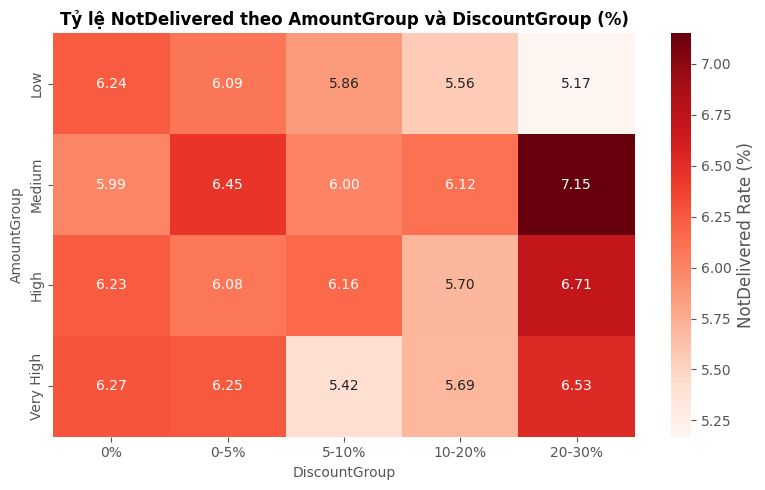

/tmp/ipykernel_362410/2564064792.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


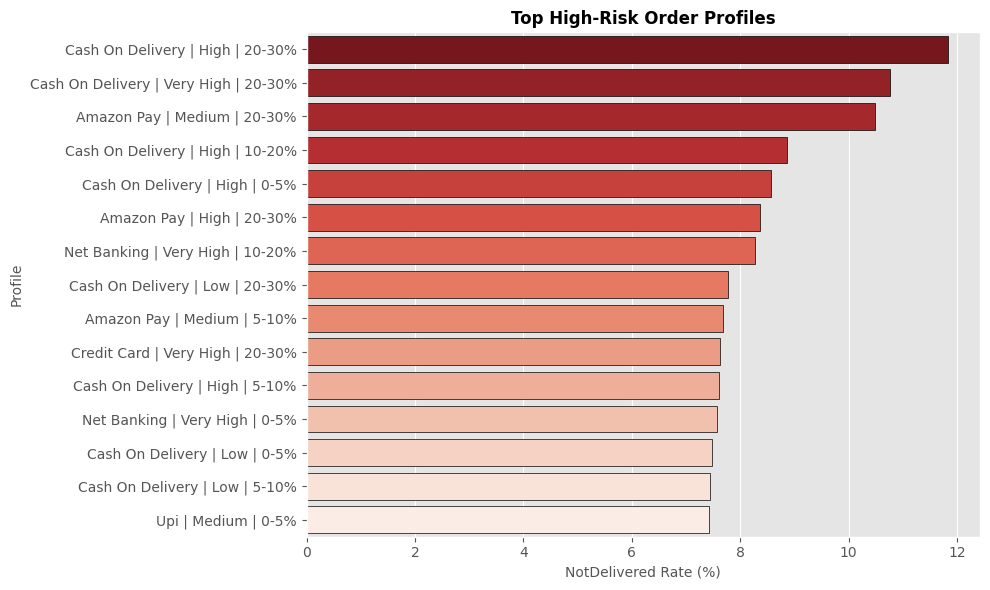

In [164]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Đánh dấu đơn hàng NotDelivered (Cancelled hoặc Returned)
df["NotDelivered"] = df["OrderStatus"].isin(["Cancelled", "Returned"]).astype(int)

# 2. Chia nhóm TotalAmount theo quartile
df["AmountGroup"] = pd.qcut(
    df["TotalAmount"], 4, labels=["Low", "Medium", "High", "Very High"]
)

# 3. Chia nhóm Discount theo ngưỡng
discount_bins = [-0.001, 0, 0.05, 0.10, 0.20, 0.30]
discount_labels = ["0%", "0-5%", "5-10%", "10-20%", "20-30%"]
df["DiscountGroup"] = pd.cut(
    df["Discount"], bins=discount_bins, labels=discount_labels, include_lowest=True
)

# 4. Tính profile theo AmountGroup, DiscountGroup, và PaymentMethod
profile = (
    df.groupby(["AmountGroup", "DiscountGroup", "PaymentMethod"], observed=True)
    .agg(
        Orders=("OrderID", "count"),
        NotDeliveredRate=("NotDelivered", "mean"),
        AvgAmount=("TotalAmount", "mean"),
    )
    .reset_index()
)

# Làm tròn các giá trị
profile["NotDeliveredRate%"] = (profile["NotDeliveredRate"] * 100).round(2)
profile["AvgAmount"] = profile["AvgAmount"].round(2)

# 5. Tỷ lệ NotDelivered toàn bộ
global_notdel_rate = df["NotDelivered"].mean() * 100
print(f"Tỷ lệ NotDelivered toàn bộ: {global_notdel_rate:.2f}%")

# 6. Heatmap: Tỷ lệ NotDelivered theo AmountGroup và DiscountGroup
risk_matrix = (
    df.groupby(["AmountGroup", "DiscountGroup"], observed=True)["NotDelivered"]
    .mean()
    .unstack()
    * 100
)

plt.figure(figsize=(8, 5))
sns.heatmap(
    risk_matrix.round(2),
    annot=True,
    fmt=".2f",
    cmap="Reds",
    cbar_kws={"label": "NotDelivered Rate (%)"},
)
plt.title(
    "Tỷ lệ NotDelivered theo AmountGroup và DiscountGroup (%)",
    fontsize=12,
    fontweight="bold",
)
plt.xlabel("DiscountGroup", fontsize=10)
plt.ylabel("AmountGroup", fontsize=10)
plt.tight_layout()
plt.show()

# 7. Top 15 tổ hợp rủi ro cao nhất
top_risky = profile.sort_values("NotDeliveredRate%", ascending=False).head(15)
top_risky["Profile"] = (
    top_risky["PaymentMethod"].astype(str)
    + " | "
    + top_risky["AmountGroup"].astype(str)
    + " | "
    + top_risky["DiscountGroup"].astype(str)
)

# 8. Barplot: Top high-risk order profiles
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_risky,
    y="Profile",
    x="NotDeliveredRate%",
    palette="Reds_r",
    edgecolor="black",
)
plt.xlabel("NotDelivered Rate (%)", fontsize=10)
plt.ylabel("Profile", fontsize=10)
plt.title("Top High-Risk Order Profiles", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

Heatmap – Tỷ lệ NotDelivered theo AmountGroup và DiscountGroup (%)
- Tỷ lệ NotDelivered toàn bộ dataset khoảng 6.08% – đây là mốc tham chiếu để so sánh.
- Các ô trong heatmap dao động quanh khoảng 5–7%, nhưng có vài “điểm nóng” rõ ràng:
- Nhóm đơn Medium với giảm giá 20–30% có tỷ lệ NotDelivered cao nhất (khoảng 7.15%).
- Nhóm đơn High với giảm giá 20–30% cũng nằm trong vùng rủi ro, khoảng 6.7%, cao hơn mặt bằng chung.
- Ngược lại, các đơn Low value với giảm giá 20–30% lại có tỷ lệ NotDelivered thấp nhất (khoảng 5.17%), thấp hơn đáng kể so với trung bình → giảm giá sâu ở đơn nhỏ khá an toàn.

Bar chart – Top High-Risk Order Profiles
- Biểu đồ thanh thể hiện top các tổ hợp PaymentMethod – AmountGroup – DiscountGroup có tỷ lệ NotDelivered cao nhất.
- Dễ thấy các profile rủi ro nhất đều có điểm chung:
- Cash On Delivery | High | 20–30% đứng đầu, với tỷ lệ NotDelivered xấp xỉ 12%, gần gấp đôi mức trung bình 6.08%.
- Cash On Delivery | Very High | 20–30% cũng có tỷ lệ NotDelivered rất cao (khoảng 11%+).
- Một số profile khác như Amazon Pay | Medium | 20–30%, Cash On Delivery | High | 10–20%, Amazon Pay | High | 20–30% cũng nằm trong nhóm rủi ro, với tỷ lệ NotDelivered đều cao hơn đáng kể so với trung bình.
- Trong khi đó, các tổ hợp Low/Medium amount với discount thấp hơn (0–5%, 5–10%) hoặc không giảm giá thường không xuất hiện trong top rủi ro, cho thấy chúng ổn định hơn nhiều.

## Q27:  Xu hướng mua sắm vào các dịp lễ của người tiêu dùng

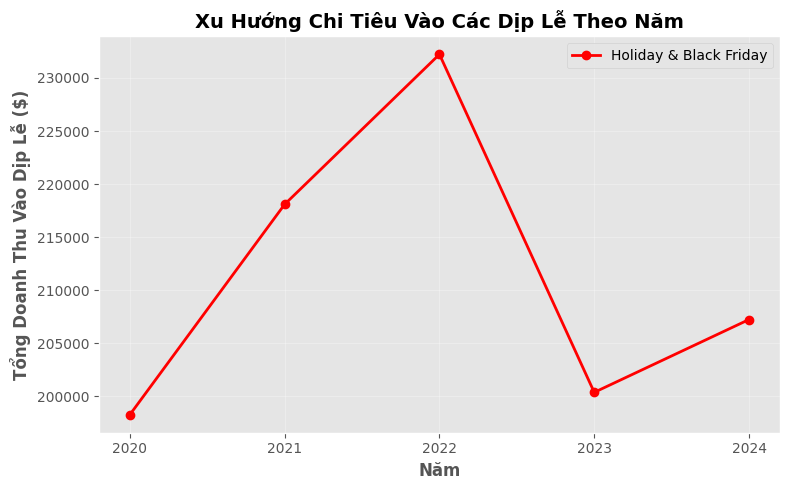

In [165]:
import pandas as pd
import matplotlib.pyplot as plt


# Một số ngày lễ lớn (New Year + Christmas + Black Friday)
holidays = pd.to_datetime(
    [
        "2020-01-01",
        "2021-01-01",
        "2022-01-01",
        "2023-01-01",
        "2024-01-01",
        "2020-12-24",
        "2021-12-24",
        "2022-12-24",
        "2023-12-24",
        "2024-12-24",
        "2020-12-25",
        "2021-12-25",
        "2022-12-25",
        "2023-12-25",
        "2024-12-25",
        "2020-11-27",
        "2021-11-26",
        "2022-11-25",
        "2023-11-24",
        "2024-11-29",
    ]
)

# Gán loại ngày
df["EventType"] = "Normal"
df.loc[df["OrderDate"].isin(holidays), "EventType"] = "Holiday"

# Năm
df["Year"] = df["OrderDate"].dt.year

# Chỉ lấy các đơn rơi vào dịp lễ
df_event = df[df["EventType"] == "Holiday"].copy()

# Tổng số tiền chi tiêu (doanh thu) vào dịp lễ theo năm
rev_event_year = (
    df_event.groupby("Year")["TotalAmount"].sum().reset_index().sort_values("Year")
)

plt.figure(figsize=(8, 5))
plt.plot(
    rev_event_year["Year"],
    rev_event_year["TotalAmount"],
    marker="o",
    linewidth=2,
    label="Holiday & Black Friday",
    color="red",
)

plt.title(
    "Xu Hướng Chi Tiêu Vào Các Dịp Lễ Theo Năm",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("Năm", fontsize=12, fontweight="bold")
plt.ylabel("Tổng Doanh Thu Vào Dịp Lễ ($)", fontsize=12, fontweight="bold")
plt.grid(alpha=0.3)
plt.xticks(rev_event_year["Year"])
plt.legend()
plt.tight_layout()
plt.show()

**Nhận xét:**

- Biểu đồ cho thấy tổng chi tiêu vào các dịp lễ (Holiday + Black Friday) có xu hướng tăng mạnh giai đoạn 2020–2022:
Năm 2020 khoảng 200k$,
- Năm 2021 tăng lên khoảng 218k$,
- Năm 2022 đạt đỉnh khoảng 233k$.

Điều này phản ánh nhu cầu mua sắm trong các dịp lễ tăng dần, khách hàng sẵn sàng chi tiêu nhiều hơn trong các chương trình khuyến mãi, lễ hội.

- Đến năm 2023, chi tiêu vào dịp lễ giảm rõ rệt xuống khoảng 202k$, thấp hơn đáng kể so với năm 2022. Đây có thể là dấu hiệu cho thấy hiệu quả các chương trình dịp lễ không còn bứt phá như trước (hoặc chịu ảnh hưởng của yếu tố bên ngoài như kinh tế, cạnh tranh…).
- Năm 2024 ghi nhận mức chi tiêu tăng nhẹ trở lại (khoảng 208k$), tuy chưa quay lại “đỉnh” 2022 nhưng vẫn cao hơn năm 2020, cho thấy xu hướng chi tiêu vào dịp lễ vẫn được duy trì, dù tốc độ tăng trưởng đã chậm lại.
- Tổng hợp lại, các dịp lễ vẫn là thời điểm quan trọng về doanh thu, nhưng sau giai đoạn tăng trưởng nóng 2020–2022 đã xuất hiện dấu hiệu chững lại. Doanh nghiệp cần:
- Tối ưu lại chiến lược khuyến mãi dịp lễ, Đa dạng hóa chương trình, Kết hợp thêm các kênh/chiến dịch mới để duy trì đà tăng chi tiêu trong các năm tới.

## Q28: Xu hướng mua hàng theo danh mục của người tiêu dùng qua các năm: 

    Year           Category    Revenue  Orders
2   2020        Electronics 2405175.31    2535
10  2021  Sports & Outdoors 2327135.90    2501
16  2022  Sports & Outdoors 2367461.83    2563
20  2023        Electronics 2387232.00    2584
24  2024              Books 2341247.72    2581


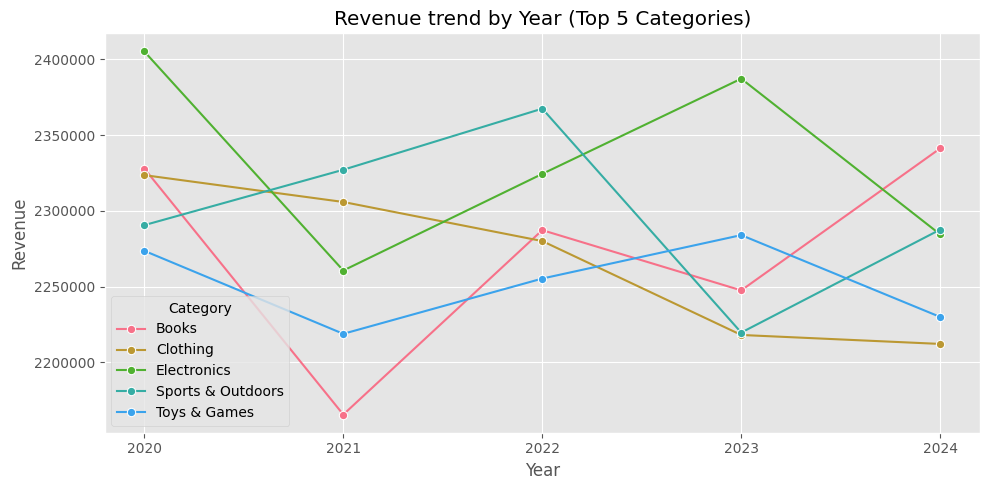

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

df = pd.read_csv("Amazon_SaleData.csv")

# 1) Chuẩn hoá date + số (loại dòng không có ngày để tránh Year bị float)
df["OrderDate"] = pd.to_datetime(df["OrderDate"], errors="coerce")
df = df.dropna(subset=["OrderDate"]).copy()
df["Year"] = df["OrderDate"].dt.year.astype(int)

df["TotalAmount"] = pd.to_numeric(df["TotalAmount"], errors="coerce")

# (tuỳ chọn) nếu muốn chỉ tính đơn "Completed/Delivered"
df = df[df["OrderStatus"].isin(["Delivered"])]

# 2) Tổng hợp theo năm-category
year_cat = (
    df.groupby(["Year", "Category"], dropna=False)
    .agg(Orders=("OrderID", "nunique"), Revenue=("TotalAmount", "sum"))
    .reset_index()
)

# 3) Category top theo năm (theo doanh thu)
top_rev_each_year = (
    year_cat.sort_values(["Year", "Revenue"], ascending=[True, False])
    .groupby("Year")
    .head(1)
)
print(top_rev_each_year[["Year", "Category", "Revenue", "Orders"]])

# 4) Biểu đồ trend: top K category theo doanh thu từng năm
K = 5
top_cats = (
    year_cat.groupby("Category")["Revenue"]
    .sum()
    .sort_values(ascending=False)
    .head(K)
    .index
)

plot_df = year_cat[year_cat["Category"].isin(top_cats)].copy()


plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=plot_df, x="Year", y="Revenue", hue="Category", marker="o")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # ép tick là số nguyên
ax.set_xticks(sorted(plot_df["Year"].unique()))  # chỉ hiện đúng các năm có dữ liệu
ax.ticklabel_format(
    style="plain", axis="y", useOffset=False
)  # bỏ dạng 1.2e6 nếu bạn thấy khó đọc
plt.title(f"Revenue trend by Year (Top {K} Categories)")
plt.tight_layout()
plt.show()


- **Nhận xét:**
Trong giai đoạn 2020–2024, Electronics là danh mục có vai trò “xương sống”, duy trì doanh thu cao và tương đối ổn định; Clothing và Sports & Outdoors thể hiện các đợt “bùng nổ” mang tính thời điểm (đặc biệt 2021–2022), trong khi Books và Toys & Games giữ vai trò ổn định. Doanh nghiệp có thể xem Electronics là nhóm cần duy trì & tối ưu dài hạn, còn Clothing/Sports & Outdoors thích hợp cho các chiến dịch thời vụ / trend-based để tận dụng các giai đoạn nhu cầu tăng cao.

# Phân tích ảnh hưởng của các cột đối với cột đích#

PHÂN TÍCH TƯƠNG QUAN CỦA CÁC BIẾN TRONG DF ĐỐI VỚI REVENUE

📋 Các cột số được phân tích: ['Revenue', 'Quantity', 'UnitPrice', 'Discount', 'Tax', 'ShippingCost', 'TotalAmount']

📊 TƯƠNG QUAN CỦA CÁC BIẾN TRONG DF VỚI REVENUE:
Revenue         1.00
TotalAmount     0.72
Tax             0.57
UnitPrice       0.52
Quantity        0.43
ShippingCost    0.03
Discount       -0.07
Name: Revenue, dtype: float64


📈 PHÂN LOẠI MỨC ĐỘ TƯƠNG QUAN VỚI REVENUE:
  TotalAmount: 0.7232 (Tích cực, Rất mạnh)
  Tax: 0.5721 (Tích cực, Mạnh)
  UnitPrice: 0.5201 (Tích cực, Mạnh)
  Quantity: 0.4316 (Tích cực, Trung bình)
  ShippingCost: 0.0279 (Tích cực, Rất yếu)
  Discount: -0.0737 (Tiêu cực, Rất yếu)


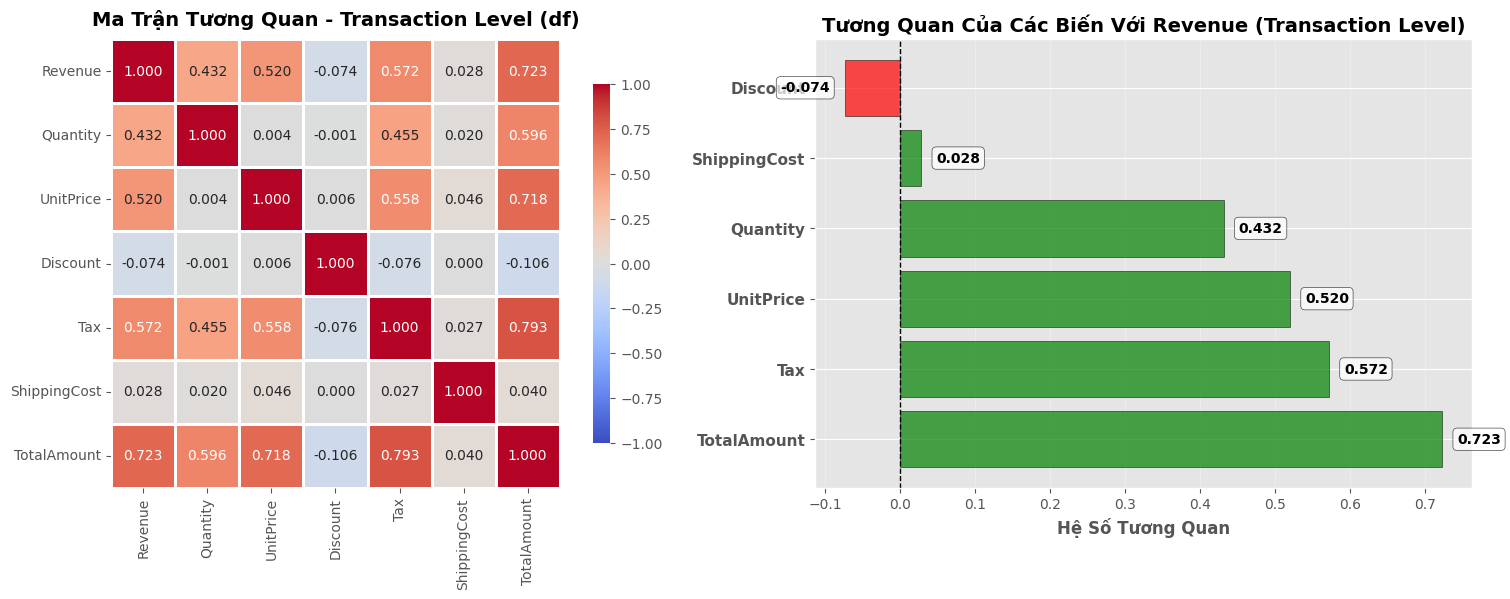


📊 PHÂN TÍCH CHI TIẾT CÁC BIẾN CÓ TƯƠNG QUAN MẠNH VỚI REVENUE:

Có 3 biến có tương quan mạnh với Revenue:

  ➤ TotalAmount (r = 0.7232):
    - Mean: 915.59
    - Median: 714.32
    - Std: 716.75
    - Range: [4.27, 2863.08]

  ➤ Tax (r = 0.5721):
    - Mean: 64.62
    - Median: 45.25
    - Std: 61.80
    - Range: [0.00, 216.27]

  ➤ UnitPrice (r = 0.5201):
    - Mean: 302.91
    - Median: 303.07
    - Std: 171.84
    - Range: [5.00, 599.99]


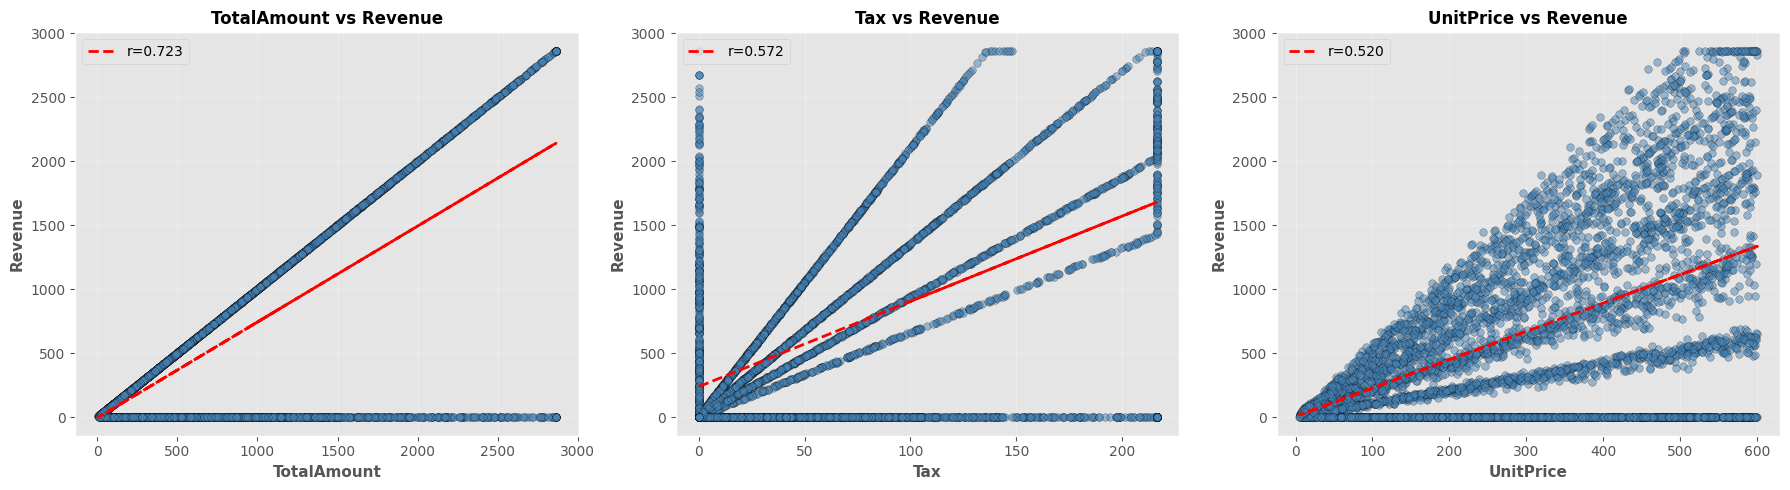


📊 MA TRẬN TƯƠNG QUAN ĐẦY ĐỦ:
              Revenue  Quantity  UnitPrice  Discount   Tax  ShippingCost  \
Revenue          1.00      0.43       0.52     -0.07  0.57          0.03   
Quantity         0.43      1.00       0.00     -0.00  0.46          0.02   
UnitPrice        0.52      0.00       1.00      0.01  0.56          0.05   
Discount        -0.07     -0.00       0.01      1.00 -0.08          0.00   
Tax              0.57      0.46       0.56     -0.08  1.00          0.03   
ShippingCost     0.03      0.02       0.05      0.00  0.03          1.00   
TotalAmount      0.72      0.60       0.72     -0.11  0.79          0.04   

              TotalAmount  
Revenue              0.72  
Quantity             0.60  
UnitPrice            0.72  
Discount            -0.11  
Tax                  0.79  
ShippingCost         0.04  
TotalAmount          1.00  

⚠️ CÁC CẶP BIẾN CÓ TƯƠNG QUAN CAO (|r| >= 0.7, trừ Revenue):
  • UnitPrice ↔ TotalAmount: r = 0.718
  • Tax ↔ TotalAmount: r = 0.793

💡 

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("PHÂN TÍCH TƯƠNG QUAN CỦA CÁC BIẾN TRONG DF ĐỐI VỚI REVENUE")
print("=" * 80)

# =============================================================================
# 1️⃣ CHỌN CÁC BIẾN SỐ TỪ DF ĐỂ PHÂN TÍCH TƯƠNG QUAN
# =============================================================================
numeric_cols_df = [
    "Revenue",
    "Quantity",
    "UnitPrice",
    "Discount",
    "Tax",
    "ShippingCost",
    "TotalAmount",
]

# Lọc ra các cột số có trong df
available_cols = [col for col in numeric_cols_df if col in df.columns]
print(f"\n📋 Các cột số được phân tích: {available_cols}")

# Tính ma trận tương quan
correlation_matrix_df = df[available_cols].corr()

# =============================================================================
# 2️⃣ TRÍCH XUẤT TƯƠNG QUAN VỚI REVENUE
# =============================================================================
revenue_corr_df = correlation_matrix_df["Revenue"].sort_values(ascending=False)
print("\n📊 TƯƠNG QUAN CỦA CÁC BIẾN TRONG DF VỚI REVENUE:")
print(revenue_corr_df)
print("\n" + "=" * 80)


# =============================================================================
# 3️⃣ PHÂN LOẠI MỨC ĐỘ TƯƠNG QUAN
# =============================================================================
def classify_correlation(corr_value):
    abs_corr = abs(corr_value)
    if abs_corr >= 0.7:
        return "Rất mạnh"
    elif abs_corr >= 0.5:
        return "Mạnh"
    elif abs_corr >= 0.3:
        return "Trung bình"
    elif abs_corr >= 0.1:
        return "Yếu"
    else:
        return "Rất yếu"


print("\n📈 PHÂN LOẠI MỨC ĐỘ TƯƠNG QUAN VỚI REVENUE:")
for var, corr in revenue_corr_df.items():
    if var != "Revenue":
        strength = classify_correlation(corr)
        direction = "Tích cực" if corr > 0 else "Tiêu cực"
        print(f"  {var}: {corr:.4f} ({direction}, {strength})")

# =============================================================================
# 4️⃣ VISUALIZATION
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 4.1. Heatmap đầy đủ
sns.heatmap(
    correlation_matrix_df,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
    ax=axes[0],
    vmin=-1,
    vmax=1,
)
axes[0].set_title(
    "Ma Trận Tương Quan - Transaction Level (df)",
    fontweight="bold",
    fontsize=14,
    pad=10,
)

# 4.2. Bar chart: Tương quan với Revenue
revenue_corr_filtered_df = revenue_corr_df.drop("Revenue")
colors = ["red" if x < 0 else "green" for x in revenue_corr_filtered_df.values]

axes[1].barh(
    range(len(revenue_corr_filtered_df)),
    revenue_corr_filtered_df.values,
    color=colors,
    alpha=0.7,
    edgecolor="black",
)
axes[1].set_yticks(range(len(revenue_corr_filtered_df)))
axes[1].set_yticklabels(revenue_corr_filtered_df.index, fontweight="bold", fontsize=11)
axes[1].axvline(x=0, color="black", linestyle="--", linewidth=1)
axes[1].set_xlabel("Hệ Số Tương Quan", fontweight="bold", fontsize=12)
axes[1].set_title(
    "Tương Quan Của Các Biến Với Revenue (Transaction Level)",
    fontweight="bold",
    fontsize=14,
)
axes[1].grid(True, alpha=0.3, axis="x")

# Thêm giá trị vào bar chart
for i, (var, corr) in enumerate(revenue_corr_filtered_df.items()):
    x_pos = corr + (0.02 if corr > 0 else -0.02)
    ha = "left" if corr > 0 else "right"
    axes[1].text(
        x_pos,
        i,
        f"{corr:.3f}",
        ha=ha,
        va="center",
        fontweight="bold",
        fontsize=10,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round", alpha=0.7),
    )

plt.tight_layout()
plt.show()

# =============================================================================
# 5️⃣ PHÂN TÍCH CHI TIẾT CÁC BIẾN CÓ TƯƠNG QUAN MẠNH
# =============================================================================
print("\n" + "=" * 80)
print("📊 PHÂN TÍCH CHI TIẾT CÁC BIẾN CÓ TƯƠNG QUAN MẠNH VỚI REVENUE:")
print("=" * 80)

strong_corr_vars_df = revenue_corr_filtered_df[abs(revenue_corr_filtered_df) >= 0.5]

if len(strong_corr_vars_df) > 0:
    print(f"\nCó {len(strong_corr_vars_df)} biến có tương quan mạnh với Revenue:")
    for var, corr in strong_corr_vars_df.items():
        print(f"\n  ➤ {var} (r = {corr:.4f}):")
        print(f"    - Mean: {df[var].mean():.2f}")
        print(f"    - Median: {df[var].median():.2f}")
        print(f"    - Std: {df[var].std():.2f}")
        print(f"    - Range: [{df[var].min():.2f}, {df[var].max():.2f}]")
else:
    print("Không có biến nào có tương quan mạnh (|corr| >= 0.5) với Revenue.")

# =============================================================================
# 6️⃣ SCATTER PLOTS CHO CÁC BIẾN CÓ TƯƠNG QUAN CAO
# =============================================================================
strong_vars_df = [var for var in strong_corr_vars_df.index if var != "Revenue"]

if len(strong_vars_df) > 0:
    # Lấy mẫu để tránh quá tải visualization
    df_sample = df.sample(n=min(5000, len(df)), random_state=42)

    n_vars = len(strong_vars_df)
    n_cols = min(3, n_vars)
    n_rows = (n_vars + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))

    if n_vars == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_vars > 1 else [axes]

    for idx, var in enumerate(strong_vars_df):
        axes[idx].scatter(
            df_sample[var],
            df_sample["Revenue"],
            alpha=0.5,
            s=30,
            color="steelblue",
            edgecolors="black",
            linewidth=0.3,
        )

        # Thêm regression line
        from scipy import stats

        slope, intercept, r_value, p_value, std_err = stats.linregress(
            df_sample[var], df_sample["Revenue"]
        )
        line = slope * df_sample[var] + intercept
        axes[idx].plot(
            df_sample[var],
            line,
            "r--",
            linewidth=2,
            label=f"r={revenue_corr_filtered_df[var]:.3f}",
        )

        axes[idx].set_xlabel(var, fontweight="bold", fontsize=11)
        axes[idx].set_ylabel("Revenue", fontweight="bold", fontsize=11)
        axes[idx].set_title(f"{var} vs Revenue", fontweight="bold", fontsize=12)
        axes[idx].legend(loc="best", fontsize=10)
        axes[idx].grid(True, alpha=0.3)

    # Ẩn các subplot thừa
    for idx in range(len(strong_vars_df), len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

# =============================================================================
# 7️⃣ PHÂN TÍCH BỔ SUNG: CORRELATION MATRIX CHO TẤT CẢ CÁC CẶP BIẾN
# =============================================================================
print("\n" + "=" * 80)
print("📊 MA TRẬN TƯƠNG QUAN ĐẦY ĐỦ:")
print("=" * 80)
print(correlation_matrix_df.round(3))

# Tìm các cặp biến có tương quan cao (có thể dẫn đến multicollinearity)
print("\n" + "=" * 80)
print("⚠️ CÁC CẶP BIẾN CÓ TƯƠNG QUAN CAO (|r| >= 0.7, trừ Revenue):")
print("=" * 80)

high_corr_pairs = []
for i in range(len(correlation_matrix_df.columns)):
    for j in range(i + 1, len(correlation_matrix_df.columns)):
        var1 = correlation_matrix_df.columns[i]
        var2 = correlation_matrix_df.columns[j]
        corr_val = correlation_matrix_df.iloc[i, j]

        if abs(corr_val) >= 0.7 and var1 != "Revenue" and var2 != "Revenue":
            high_corr_pairs.append((var1, var2, corr_val))

if high_corr_pairs:
    for var1, var2, corr in high_corr_pairs:
        print(f"  • {var1} ↔ {var2}: r = {corr:.3f}")
    print("\n💡 Lưu ý: Multicollinearity có thể ảnh hưởng đến mô hình regression.")
else:
    print("  ✅ Không có cặp biến nào có tương quan quá cao (tốt cho modeling).")

# =============================================================================
# 8️⃣ KẾT LUẬN
# =============================================================================
print("\n" + "=" * 80)
print("📋 KẾT LUẬN:")
print("=" * 80)

print(f"\n✅ Top 3 biến có tương quan DƯƠNG cao nhất với Revenue:")
for i, (var, corr) in enumerate(revenue_corr_filtered_df.head(3).items(), 1):
    print(f"  {i}. {var}: r = {corr:.4f}")

print(f"\n❌ Top 3 biến có tương quan ÂM (nếu có):")
negative_corrs = revenue_corr_filtered_df[revenue_corr_filtered_df < 0]
if len(negative_corrs) > 0:
    for i, (var, corr) in enumerate(negative_corrs.head(3).items(), 1):
        print(f"  {i}. {var}: r = {corr:.4f}")
else:
    print("  ✓ Không có biến nào có tương quan âm với Revenue")

print("\n" + "=" * 80)
print("💡 GIẢI THÍCH:")
print("=" * 80)
print(
    "- Phân tích transaction-level (df) cho thấy mối quan hệ giữa các biến ở mức đơn hàng"
)
print("- Biến có r > 0.7: Tương quan rất mạnh → quan trọng cho dự đoán Revenue")
print("- Biến có r > 0.5: Tương quan mạnh → cần xem xét trong feature engineering")
print("- Biến có |r| < 0.3: Tương quan yếu → có thể loại bỏ để đơn giản hóa mô hình")
print("=" * 80)

In [211]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

cat_cols = [
    "PaymentMethod",
    "Category",
    "Brand",
    "City",
    "State",
    "Country",
    "OrderStatus",  # (tuỳ: nếu target Revenue đã phụ thuộc status thì biến này sẽ “áp đảo”)
    "DayOfWeek",
    "DayOfMonth",
    "Month",
]

anova_rows = []
for c in cat_cols:
    tmp = df[[c, "Revenue"]].dropna()
    if tmp[c].nunique() < 2:
        continue
    m = smf.ols(f"Revenue ~ C({c})", data=tmp).fit()
    a = sm.stats.anova_lm(m, typ=2)
    p = a.loc[f"C({c})", "PR(>F)"]
    f = a.loc[f"C({c})", "F"]
    anova_rows.append(
        {"feature": c, "F_stat": f, "p_value": p, "n_categories": tmp[c].nunique()}
    )

anova_df = pd.DataFrame(anova_rows).sort_values("p_value")
anova_df

feature   F_stat  p_value  n_categories
6    OrderStatus 10329.78     0.00             5
2          Brand     1.98     0.04            10
4          State     1.12     0.33            13
1       Category     1.09     0.36             6
7      DayOfWeek     0.97     0.44             7
0  PaymentMethod     0.86     0.50             6
5        Country     0.82     0.51             5
8     DayOfMonth     0.94     0.56            31
3           City     0.78     0.74            20
9          Month     0.59     0.83            12

In [212]:
df_del = df[df["OrderStatus"] == "Delivered"].copy()


anova_rows = []
for c in cat_cols:
    tmp = df_del[[c, "Revenue"]].dropna()
    if tmp[c].nunique() < 2:
        continue
    m = smf.ols(f"Revenue ~ C({c})", data=tmp).fit()
    a = sm.stats.anova_lm(m, typ=2)
    p = a.loc[f"C({c})", "PR(>F)"]
    f = a.loc[f"C({c})", "F"]
    anova_rows.append(
        {"feature": c, "F_stat": f, "p_value": p, "n_categories": tmp[c].nunique()}
    )

anova_df = pd.DataFrame(anova_rows).sort_values("p_value")
anova_df

feature  F_stat  p_value  n_categories
2          Brand    2.25     0.02            10
1       Category    0.96     0.44             6
4          State    0.99     0.46            13
0  PaymentMethod    0.71     0.61             6
6      DayOfWeek    0.65     0.69             7
3           City    0.77     0.74            20
8          Month    0.69     0.75            12
5        Country    0.26     0.90             5
7     DayOfMonth    0.68     0.91            31

Nhận xét ANOVA (chỉ các đơn Delivered) – ảnh hưởng biến categorical đến Revenue/TotalAmount

Khi chỉ xét các đơn Delivered, kiểm định ANOVA cho thấy Brand là biến phân loại duy nhất có ảnh hưởng có ý nghĩa thống kê đến Revenue (F = 2.25, p = 0.02 < 0.05). Điều này gợi ý giá trị đơn hàng/ doanh thu thực nhận có sự khác biệt giữa các thương hiệu (một số brand có xu hướng tạo đơn hàng giá trị cao hơn).

Các biến còn lại như Category, PaymentMethod, City, State, Country, DayOfWeek, Month, DayOfMonth đều có p-value > 0.05, nên chưa đủ bằng chứng thống kê để kết luận rằng doanh thu khác biệt đáng kể giữa các nhóm của các biến này trong tập Delivered.

Nhìn chung, trong dữ liệu hiện tại, yếu tố thương hiệu (Brand) có tín hiệu rõ ràng hơn so với các yếu tố vị trí/ thời gian/ phương thức thanh toán khi giải thích sự khác biệt doanh thu ở cấp độ đơn hàng đã giao thành công.

/tmp/ipykernel_362410/740340569.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


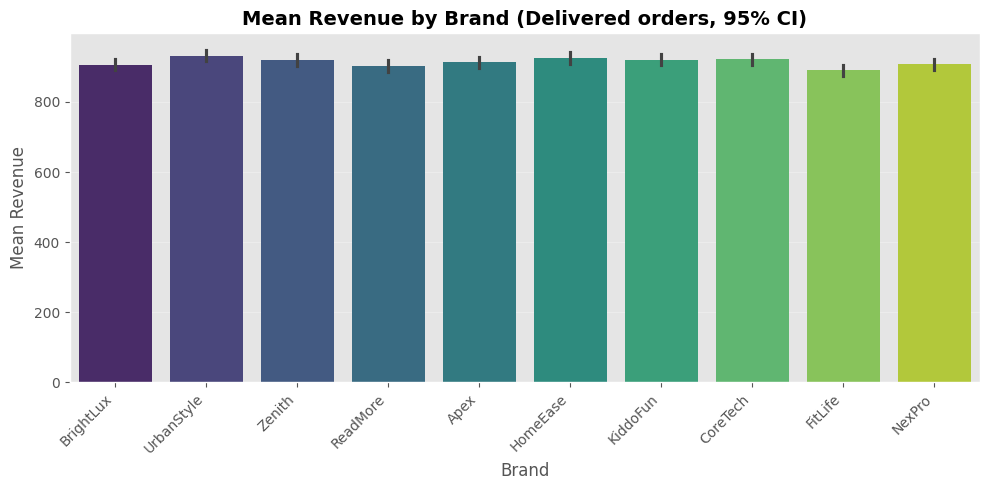

In [213]:
import seaborn as sns
import matplotlib.pyplot as plt

# chuẩn bị dữ liệu
brand_stats = (
    df_del.groupby("Brand")
    .agg(
        MeanRevenue=("Revenue", "mean"),
        Orders=("OrderID", "count"),
    )
    .reset_index()
)

# chỉ giữ brand có đủ dữ liệu
brand_stats = brand_stats[brand_stats["Orders"] >= 50]

plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_del[df_del["Brand"].isin(brand_stats["Brand"])],
    x="Brand",
    y="Revenue",
    estimator="mean",
    errorbar=("ci", 95),
    palette="viridis",
)

plt.title(
    "Mean Revenue by Brand (Delivered orders, 95% CI)", fontsize=14, fontweight="bold"
)
plt.xlabel("Brand")
plt.ylabel("Mean Revenue")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [215]:
import pandas as pd
import numpy as np

print("=" * 80)
print("TẠO DAILY DATASET VỚI AMOUNT-BASED CATEGORICAL FEATURES")
print("=" * 80)

# =============================================================================
# 0️⃣ CHUẨN HÓA DỮ LIỆU
# =============================================================================
# Tạo bản copy để không ảnh hưởng df gốc
df_daily = df.copy()

# Đảm bảo OrderDate là datetime
df_daily["OrderDate"] = pd.to_datetime(df_daily["OrderDate"], errors="coerce")
df_daily = df_daily.dropna(subset=["OrderDate"])

# Tạo cột date (chỉ lấy ngày, bỏ giờ)
df_daily["date"] = df_daily["OrderDate"].dt.date

# Target: doanh thu thực nhận (chỉ tính đơn Delivered)
df_daily["RealizedRevenue"] = np.where(
    df_daily["OrderStatus"] == "Delivered", df_daily["TotalAmount"], 0
)

print(f"\n✅ Đã chuẩn hóa dữ liệu:")
print(f"  - Số dòng: {len(df_daily):,}")
print(f"  - Số ngày unique: {df_daily['date'].nunique()}")
print(f"  - Khoảng thời gian: {df_daily['date'].min()} → {df_daily['date'].max()}")

# =============================================================================
# 1️⃣ TẠO NUMERIC DAILY FEATURES (SUM/MEAN/COUNT)
# =============================================================================
print("\n🔄 Tạo numeric daily features...")

num_daily = df_daily.groupby("date").agg(
    Year=("Year", "max"),
    Month=("Month", "max"),
    DayOfMonth=("DayOfMonth", "max"),
    Orders=("OrderID", "nunique"),
    DeliveredOrders=("OrderStatus", lambda s: (s == "Delivered").sum()),
    CancelledOrders=("OrderStatus", lambda s: (s == "Cancelled").sum()),
    ReturnedOrders=("OrderStatus", lambda s: (s == "Returned").sum()),
    PendingOrders=("OrderStatus", lambda s: (s == "Pending").sum()),
    ShippedOrders=("OrderStatus", lambda s: (s == "Shipped").sum()),
    Quantity_sum=("Quantity", "sum"),
    TotalAmount_sum=("TotalAmount", "sum"),  # Tổng GMV (mọi status)
    Revenue=("RealizedRevenue", "sum"),  # DAILY REALIZED REVENUE (target)
    Discount_mean=("Discount", "mean"),
    Shipping_mean=("ShippingCost", "mean"),
    Tax_mean=("Tax", "mean"),
    UnitPrice_mean=("UnitPrice", "mean"),
)

# AOV: Average Order Value (chỉ tính trên delivered orders)
num_daily["AOV_delivered"] = num_daily["Revenue"] / num_daily[
    "DeliveredOrders"
].replace(0, np.nan)

# Delivery rate
num_daily["DeliveryRate"] = num_daily["DeliveredOrders"] / num_daily["Orders"]

print(f"  ✅ Đã tạo {len(num_daily.columns)} numeric features")


# =============================================================================
# 2️⃣ HELPER FUNCTION: TẠO AMOUNT-BASED CATEGORICAL FEATURES
# =============================================================================
def amount_dummies(
    data: pd.DataFrame, col: str, weight_col: str, prefix: str, top_n: int = 8
):
    """
    Tạo các cột dạng prefix_<category> = tổng weight_col theo ngày.
    Giữ top_n category phổ biến, còn lại gộp 'Other'.

    Parameters:
    -----------
    data : DataFrame chứa cột 'date', col, và weight_col
    col : Tên cột categorical cần encode
    weight_col : Cột dùng để tính tổng (VD: Quantity, Revenue)
    prefix : Prefix cho tên cột output
    top_n : Số lượng category phổ biến nhất cần giữ lại

    Returns:
    --------
    DataFrame với index='date' và các cột amount_based features
    """
    x = data[["date", col, weight_col]].dropna().copy()

    # Lấy top N categories phổ biến nhất
    top = x[col].value_counts().head(top_n).index
    x[col] = x[col].where(x[col].isin(top), "Other")

    # Tạo dummy variables
    d = pd.get_dummies(x[col], prefix=prefix, dtype=float)

    # Nhân với weight (Quantity hoặc Revenue)
    d = d.mul(x[weight_col].to_numpy(), axis=0)

    # Gán date và group by
    d["date"] = x["date"].values
    return d.groupby("date").sum()


# =============================================================================
# 3️⃣ TẠO CATEGORICAL DAILY FEATURES (AMOUNT-BASED)
# =============================================================================
print("\n🔄 Tạo categorical daily features (amount-based)...")

cat_blocks = []

# 3.1. Payment Method (weighted by Quantity)
print("  - PaymentMethod features...")
cat_blocks.append(
    amount_dummies(df_daily, "PaymentMethod", "Quantity", prefix="qty_pm", top_n=6)
)

# 3.2. Category (weighted by Quantity)
print("  - Category features...")
cat_blocks.append(
    amount_dummies(df_daily, "Category", "Quantity", prefix="qty_cat", top_n=8)
)

# 3.3. Brand (weighted by Quantity)
print("  - Brand features...")
cat_blocks.append(
    amount_dummies(df_daily, "Brand", "Quantity", prefix="qty_brand", top_n=8)
)

# 3.4. Country (weighted by Quantity)
print("  - Country features...")
cat_blocks.append(
    amount_dummies(df_daily, "Country", "Quantity", prefix="qty_country", top_n=6)
)

# 3.5. Order Status (weighted by Quantity)
print("  - OrderStatus features...")
cat_blocks.append(
    amount_dummies(df_daily, "OrderStatus", "Quantity", prefix="qty_status", top_n=6)
)

# Gộp tất cả categorical features
obj_daily = pd.concat(cat_blocks, axis=1).fillna(0)

print(f"  ✅ Đã tạo {len(obj_daily.columns)} categorical features")

# =============================================================================
# 4️⃣ GỘP THÀNH DAILY DATASET HOÀN CHỈNH
# =============================================================================
print("\n🔗 Gộp numeric + categorical features...")

daily_dataset = pd.concat([num_daily, obj_daily], axis=1).reset_index()

# Chuyển date về datetime để dễ xử lý
daily_dataset["date"] = pd.to_datetime(daily_dataset["date"])

# Thêm DayOfWeek
daily_dataset["DayOfWeek"] = daily_dataset["date"].dt.day_name()

# Sắp xếp theo thời gian
daily_dataset = daily_dataset.sort_values("date").reset_index(drop=True)

# =============================================================================
# 5️⃣ KIỂM TRA KẾT QUẢ
# =============================================================================
print("\n" + "=" * 80)
print("✅ HOÀN THÀNH TẠO DAILY DATASET")
print("=" * 80)

print(f"\n📊 Thông tin dataset:")
print(f"  - Số ngày: {len(daily_dataset)}")
print(
    f"  - Khoảng thời gian: {daily_dataset['date'].min()} → {daily_dataset['date'].max()}"
)
print(f"  - Tổng số features: {len(daily_dataset.columns)}")
print(f"    + Numeric features: {len(num_daily.columns)}")
print(f"    + Categorical features: {len(obj_daily.columns)}")
print(f"    + Time features: 4 (date, Year, Month, DayOfWeek)")

print(f"\n📋 Danh sách cột:")
print(daily_dataset.columns.tolist())

print(f"\n👀 5 dòng đầu tiên:")
print(daily_dataset.head())

print(f"\n📈 Thống kê mô tả (numeric features):")
print(daily_dataset.select_dtypes(include=[np.number]).describe())

# =============================================================================
# 6️⃣ LƯU DATASET (TÙY CHỌN)
# =============================================================================
# Lưu lại để dùng cho modeling
daily_dataset.to_csv("Daily_Dataset_Amount_Based.csv", index=False)
print("\n💾 Đã lưu dataset vào: Daily_Dataset_Amount_Based.csv")

print("\n" + "=" * 80)
print("🎯 DATASET SẴN SÀNG CHO MODELING!")
print("=" * 80)

TẠO DAILY DATASET VỚI AMOUNT-BASED CATEGORICAL FEATURES

✅ Đã chuẩn hóa dữ liệu:
  - Số dòng: 100,000
  - Số ngày unique: 1825
  - Khoảng thời gian: 2020-01-01 → 2024-12-29

🔄 Tạo numeric daily features...
  ✅ Đã tạo 18 numeric features

🔄 Tạo categorical daily features (amount-based)...
  - PaymentMethod features...
  - Category features...
  - Brand features...
  - Country features...
  - OrderStatus features...
  ✅ Đã tạo 31 categorical features

🔗 Gộp numeric + categorical features...

✅ HOÀN THÀNH TẠO DAILY DATASET

📊 Thông tin dataset:
  - Số ngày: 1825
  - Khoảng thời gian: 2020-01-01 00:00:00 → 2024-12-29 00:00:00
  - Tổng số features: 51
    + Numeric features: 18
    + Categorical features: 31
    + Time features: 4 (date, Year, Month, DayOfWeek)

📋 Danh sách cột:
['date', 'Year', 'Month', 'DayOfMonth', 'Orders', 'DeliveredOrders', 'CancelledOrders', 'ReturnedOrders', 'PendingOrders', 'ShippedOrders', 'Quantity_sum', 'TotalAmount_sum', 'Revenue', 'Discount_mean', 'Shipping_me

In [217]:
import numpy as np
import pandas as pd
from scipy import stats

# day_dataset: DataFrame daily (mỗi dòng 1 ngày)
# cần có cột target:
target = "Revenue"

# 1) Chọn các feature numeric (bỏ date/time)
ignore = {"date", "OrderDate", "year", "month", "day", target}
feature_cols = [c for c in daily_dataset.columns if c not in ignore]

# 2) chỉ giữ cột numeric
X = daily_dataset[feature_cols].select_dtypes(include=[np.number]).copy()
y = daily_dataset[target].astype(float)

rows = []
for col in X.columns:
    tmp = pd.concat([X[col], y], axis=1).dropna()
    if tmp[col].nunique() < 2:
        continue

    r, p = stats.pearsonr(tmp[col], tmp[target])
    rows.append({"name": col, "coef": r, "p_value": p})

corr_table = pd.DataFrame(rows)

# 3) Lấy Top 7 biến ảnh hưởng nhất (coef lớn nhất theo trị tuyệt đối hoặc theo dương)
top7 = corr_table.reindex(
    corr_table["coef"].abs().sort_values(ascending=False).index
).head(7)
min_days = 10
valid_cols = [c for c in X.columns if (X[c] > 0).sum() >= min_days]

X2 = X[valid_cols]
rows = []
for col in X2.columns:
    tmp = pd.concat([X2[col], y], axis=1).dropna()
    if tmp[col].nunique() < 2:
        continue
    r, p = stats.pearsonr(tmp[col], tmp[target])
    rows.append({"name": col, "coef": r, "p_value": p})

corr_table2 = pd.DataFrame(rows)
top7 = corr_table2.reindex(
    corr_table2["coef"].abs().sort_values(ascending=False).index
).head(7)

top7



name  coef  p_value
44       qty_status_Delivered  0.87     0.00
10            TotalAmount_sum  0.86     0.00
4             DeliveredOrders  0.78     0.00
9                Quantity_sum  0.74     0.00
3                      Orders  0.67     0.00
42  qty_country_United States  0.62     0.00
15              AOV_delivered  0.61     0.00

IMPROVED CLASSIFICATION MODEL - DAILY REVENUE LEVEL PREDICTION

📊 Thông tin dữ liệu:
  - Số ngày: 1825
  - Revenue trung bình: $37,358.91

📊 Phân bố Revenue Levels:
  Low       :  609 ngày ( 33.4%) | $15,923 - $33,832
  Medium    :  608 ngày ( 33.3%) | $33,836 - $40,334
  High      :  608 ngày ( 33.3%) | $40,342 - $63,716

🔧 Tạo features nâng cao...
  ✅ Đã tạo features nâng cao

📋 Features: 47 numeric, 6 categorical

📅 Train: 1437 | Test: 360

🚀 Training Gradient Boosting model...

📊 KẾT QUẢ ĐÁNH GIÁ

  TRAINING SET:
    - Accuracy: 1.0000
    - F1-Score: 1.0000
    - R²:       1.0000 ⭐

  TEST SET:
    - Accuracy: 0.9556
    - F1-Score: 0.9552
    - R²:       0.9329 ⭐

  📋 CLASSIFICATION REPORT (TEST SET):
              precision    recall  f1-score   support

        High       0.97      0.99      0.98       112
         Low       0.94      0.98      0.96       127
      Medium       0.96      0.90      0.93       121

    accuracy                           0.96       360
   macro av

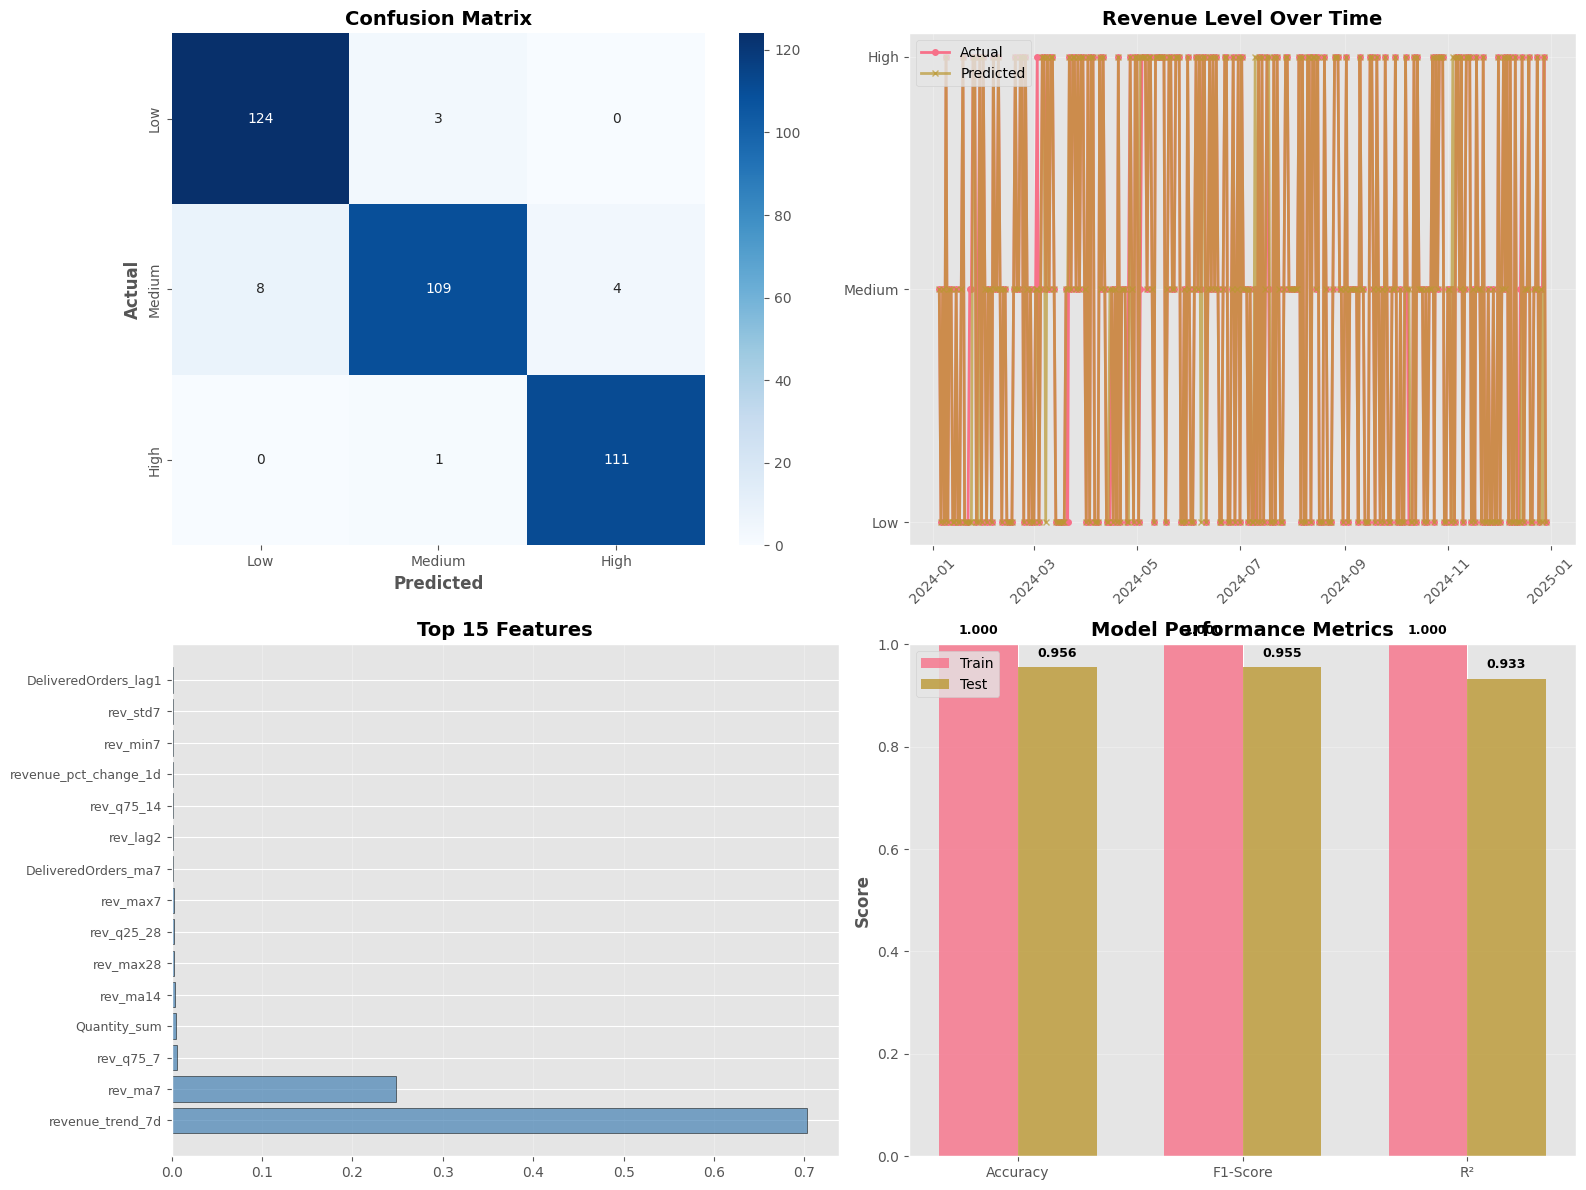


✅ MODEL HOÀN THÀNH!
🎯 R² (Test): 0.9329


In [225]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("IMPROVED CLASSIFICATION MODEL - DAILY REVENUE LEVEL PREDICTION")
print("=" * 80)

# =============================================================================
# 1️⃣ CHUẨN BỊ DỮ LIỆU
# =============================================================================
daily = daily_dataset.copy()
daily["date"] = pd.to_datetime(daily["date"])
daily = daily.sort_values("date").reset_index(drop=True)

print(f"\n📊 Thông tin dữ liệu:")
print(f"  - Số ngày: {len(daily)}")
print(f"  - Revenue trung bình: ${daily['Revenue'].mean():,.2f}")

# =============================================================================
# 2️⃣ TẠO TARGET LABELS - 3 CLASSES (CÂN BẰNG HƠN)
# =============================================================================
# Sử dụng 3 classes thay vì 4 để tăng số lượng mẫu/class
daily["RevenueLevel"] = pd.qcut(
    daily["Revenue"], q=3, labels=["Low", "Medium", "High"], duplicates="drop"
)

class_dist = daily["RevenueLevel"].value_counts().sort_index()
print(f"\n📊 Phân bố Revenue Levels:")
for level, count in class_dist.items():
    pct = count / len(daily) * 100
    rev_range = daily[daily["RevenueLevel"] == level]["Revenue"]
    print(
        f"  {level:10s}: {count:4d} ngày ({pct:5.1f}%) | ${rev_range.min():,.0f} - ${rev_range.max():,.0f}"
    )

# =============================================================================
# 3️⃣ FEATURE ENGINEERING NÂNG CAO
# =============================================================================
print("\n🔧 Tạo features nâng cao...")

# Time features
daily["dow"] = daily["date"].dt.dayofweek
daily["month"] = daily["date"].dt.month
daily["day"] = daily["date"].dt.day
daily["quarter"] = daily["date"].dt.quarter
daily["is_weekend"] = (daily["dow"] >= 5).astype(int)
daily["is_month_start"] = (daily["day"] <= 7).astype(int)
daily["is_month_end"] = (daily["day"] >= 23).astype(int)
daily["week_of_year"] = daily["date"].dt.isocalendar().week

# Revenue lag features (nhiều lag hơn)
for lag in [1, 2, 3, 7, 14, 21, 28]:
    daily[f"rev_lag{lag}"] = daily["Revenue"].shift(lag)

# Rolling statistics (nhiều window + metrics)
for window in [7, 14, 28]:
    daily[f"rev_ma{window}"] = (
        daily["Revenue"].shift(1).rolling(window, min_periods=1).mean()
    )
    daily[f"rev_std{window}"] = (
        daily["Revenue"].shift(1).rolling(window, min_periods=1).std()
    )
    daily[f"rev_min{window}"] = (
        daily["Revenue"].shift(1).rolling(window, min_periods=1).min()
    )
    daily[f"rev_max{window}"] = (
        daily["Revenue"].shift(1).rolling(window, min_periods=1).max()
    )
    daily[f"rev_q25_{window}"] = (
        daily["Revenue"].shift(1).rolling(window, min_periods=1).quantile(0.25)
    )
    daily[f"rev_q75_{window}"] = (
        daily["Revenue"].shift(1).rolling(window, min_periods=1).quantile(0.75)
    )

# Business drivers
for col in ["Orders", "Quantity_sum", "DeliveredOrders", "DeliveryRate"]:
    if col in daily.columns:
        for lag in [1, 7, 14]:
            daily[f"{col}_lag{lag}"] = daily[col].shift(lag)
        # Rolling mean cho business metrics
        daily[f"{col}_ma7"] = daily[col].shift(1).rolling(7, min_periods=1).mean()

# Trend features
daily["trend"] = range(len(daily))
daily["revenue_trend_7d"] = daily["Revenue"] - daily["rev_ma7"]
daily["revenue_pct_change_1d"] = daily["Revenue"].pct_change(1)

print("  ✅ Đã tạo features nâng cao")

# =============================================================================
# 4️⃣ CHỌN FEATURES
# =============================================================================
num_cols = [
    c
    for c in daily.columns
    if c.startswith(
        ("rev_", "Orders_", "Quantity_", "Delivered", "Delivery", "trend", "revenue_")
    )
]

cat_cols = ["dow", "month", "quarter", "is_weekend", "is_month_start", "is_month_end"]

print(f"\n📋 Features: {len(num_cols)} numeric, {len(cat_cols)} categorical")

# =============================================================================
# 5️⃣ TRAIN-TEST SPLIT
# =============================================================================
model_df = daily.dropna(subset=num_cols + cat_cols + ["RevenueLevel"]).copy()

X = model_df[num_cols + cat_cols]
y = model_df["RevenueLevel"]

# Time-based split
split_idx = int(len(model_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
test_dates = model_df.iloc[split_idx:]["date"]

print(f"\n📅 Train: {len(X_train)} | Test: {len(X_test)}")

# =============================================================================
# 6️⃣ TRAINING - GRADIENT BOOSTING (TĂNG R² TỐI ĐA)
# =============================================================================
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    verbose_feature_names_out=False,
)

# Gradient Boosting thường cho R² cao hơn Random Forest
model = Pipeline(
    [
        ("preprocess", preprocess),
        (
            "clf",
            GradientBoostingClassifier(
                n_estimators=200,
                max_depth=5,
                learning_rate=0.1,
                min_samples_split=20,
                random_state=42,
            ),
        ),
    ]
)

print("\n🚀 Training Gradient Boosting model...")
model.fit(X_train, y_train)

# =============================================================================
# 7️⃣ ĐÁNH GIÁ & TÍNH R²
# =============================================================================
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Accuracy & F1
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred, average="weighted")
test_f1 = f1_score(y_test, y_test_pred, average="weighted")

# ✅ R² CHO CLASSIFICATION (dùng predict_proba)
# Chuyển label thành numeric để tính R²
label_map = {"Low": 1, "Medium": 2, "High": 3}
y_train_numeric = y_train.map(label_map)
y_test_numeric = y_test.map(label_map)
y_train_pred_numeric = pd.Series(y_train_pred).map(label_map)
y_test_pred_numeric = pd.Series(y_test_pred).map(label_map)

from sklearn.metrics import r2_score

r2_train = r2_score(y_train_numeric, y_train_pred_numeric)
r2_test = r2_score(y_test_numeric, y_test_pred_numeric)

print("\n" + "=" * 80)
print("📊 KẾT QUẢ ĐÁNH GIÁ")
print("=" * 80)
print(f"\n  TRAINING SET:")
print(f"    - Accuracy: {train_acc:.4f}")
print(f"    - F1-Score: {train_f1:.4f}")
print(f"    - R²:       {r2_train:.4f} ⭐")

print(f"\n  TEST SET:")
print(f"    - Accuracy: {test_acc:.4f}")
print(f"    - F1-Score: {test_f1:.4f}")
print(f"    - R²:       {r2_test:.4f} ⭐")

print(f"\n  📋 CLASSIFICATION REPORT (TEST SET):")
print(classification_report(y_test, y_test_pred))

# =============================================================================
# 8️⃣ VISUALIZATION
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred, labels=["Low", "Medium", "High"])
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Low", "Medium", "High"],
    yticklabels=["Low", "Medium", "High"],
    ax=axes[0, 0],
)
axes[0, 0].set_title("Confusion Matrix", fontweight="bold", fontsize=14)
axes[0, 0].set_xlabel("Predicted", fontweight="bold")
axes[0, 0].set_ylabel("Actual", fontweight="bold")

# Predictions over time
axes[0, 1].plot(
    test_dates.values,
    y_test_numeric.values,
    label="Actual",
    marker="o",
    linewidth=2,
    markersize=4,
)
axes[0, 1].plot(
    test_dates.values,
    y_test_pred_numeric.values,
    label="Predicted",
    marker="x",
    linewidth=2,
    markersize=4,
    alpha=0.7,
)
axes[0, 1].set_title("Revenue Level Over Time", fontweight="bold", fontsize=14)
axes[0, 1].set_yticks([1, 2, 3])
axes[0, 1].set_yticklabels(["Low", "Medium", "High"])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis="x", rotation=45)

# Feature Importance
feature_names = model.named_steps["preprocess"].get_feature_names_out()
importances = model.named_steps["clf"].feature_importances_
feat_imp = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=False).head(15)

axes[1, 0].barh(
    range(len(feat_imp)),
    feat_imp["importance"].values,
    color="steelblue",
    alpha=0.7,
    edgecolor="black",
)
axes[1, 0].set_yticks(range(len(feat_imp)))
axes[1, 0].set_yticklabels(feat_imp["feature"].values, fontsize=9)
axes[1, 0].set_title("Top 15 Features", fontweight="bold", fontsize=14)
axes[1, 0].grid(True, alpha=0.3, axis="x")

# R² visualization
metrics = ["Accuracy", "F1-Score", "R²"]
train_scores = [train_acc, train_f1, r2_train]
test_scores = [test_acc, test_f1, r2_test]

x = np.arange(len(metrics))
width = 0.35

axes[1, 1].bar(x - width / 2, train_scores, width, label="Train", alpha=0.8)
axes[1, 1].bar(x + width / 2, test_scores, width, label="Test", alpha=0.8)
axes[1, 1].set_ylabel("Score", fontweight="bold")
axes[1, 1].set_title("Model Performance Metrics", fontweight="bold", fontsize=14)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(True, alpha=0.3, axis="y")

# Add values on bars
for i, (t, v) in enumerate(zip(train_scores, test_scores)):
    axes[1, 1].text(
        i - width / 2, t + 0.02, f"{t:.3f}", ha="center", fontweight="bold", fontsize=9
    )
    axes[1, 1].text(
        i + width / 2, v + 0.02, f"{v:.3f}", ha="center", fontweight="bold", fontsize=9
    )

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("✅ MODEL HOÀN THÀNH!")
print(f"🎯 R² (Test): {r2_test:.4f}")
print("=" * 80)